In [3]:
import pandas as pd
import os
import re
from tqdm import tqdm
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, pairwise
import io
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from openai import OpenAI
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage, AIMessage
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser


In [4]:
file_names = os.listdir('database/pdfs_test')

# keep only pdf files and extract doc ids
file_names = [f[:-4] for f in file_names if f.endswith('.pdf')]

file_names = sorted(file_names)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


dfs = []
for file_name in tqdm(file_names, desc='Processing files'):
    df = pd.read_parquet(f'outputs/train/{file_name}/initial_df.parquet')

    df.loc[df.page_number == 0, 'noise_type'] = 'cover'
    df.loc[df.page_number == 0, 'is_noise'] = True

    dfs.append(df)


first_pages = [df[(df.page_number!=0)&(df.page_number <= 5)] for df in dfs]
# append each df to the other
first_pages = pd.concat(first_pages)


def replace_numbers_with_npage(text):
    protected_pattern = re.compile(r'(?i)(item\s+)(\d{1,3})')  # (?i) for case-insensitive
    protected_text = protected_pattern.sub(r'\1ITEM_PROTECTED_\2', text)
    
    # Step 2: Replace all remaining standalone numbers up to 3 digits with '[number]'
    replace_pattern = re.compile(r'\b\d{1,3}\b')
    replaced_text = replace_pattern.sub(' [number] ', protected_text)

    # step 4: replace all 4 digit numbers with '[year]'
    replace_pattern = re.compile(r'\b\d{4}\b')
    replaced_text = replace_pattern.sub(' [year] ', replaced_text)

    
    # Step 4: Restore the protected numbers by removing the placeholder
    # Replace 'ITEM_PROTECTED_<number>' back to the original number
    restore_pattern = re.compile(r'ITEM_PROTECTED_(\d{1,3})')
    final_text = restore_pattern.sub(r'\1', replaced_text)
    # collapse multiple spaces 
    final_text = re.sub(r'\S{26,}', ' ', text)
    final_text = re.sub(r'  ', ' ', final_text)
    final_text = re.sub(r'\n ', '\n', final_text)
    final_text = re.sub(r' \n', '\n', final_text)
    
    
    return final_text

def preprocess(text):
    # Replace URLs starting with https with a space
    text = re.sub(r'https\S+', ' ', text)
    # Tokenize the text
    text = text.replace('\n', ' ')
    # text remove all non alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    # collapse multiple spaces
    text = re.sub(r'  ', ' ', text)
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation
    # tokens = [word for word in tokens if word.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)


# drop all columns except doc_id, page_number, clean_text, is_noise, noise_type
first_pages = first_pages[['doc_id', 'page_number', 'clean_text', 'is_noise', 'noise_type']]
# group by doc_id and page_number and join clean_text with new lines
first_pages = first_pages.groupby(['doc_id', 'page_number']).agg({'clean_text': '\n'.join}).reset_index()

first_pages['masked_text'] = first_pages['clean_text'].apply(replace_numbers_with_npage)
first_pages['masked_text'] = first_pages['masked_text'].apply(preprocess)


first_pages



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emanueleferrari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emanueleferrari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/emanueleferrari/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Processing files:   0%|          | 0/50 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/train/ts00_0000004127_0000004127-13-000056/initial_df.parquet'

# Labelling 

In [201]:
# from IPython.display import clear_output

# # Add new columns for cover and toc
# first_pages['cover'] = False
# first_pages['toc'] = False

# for index, row in first_pages.iterrows():
#     print(f"Doc ID: {row['doc_id']}, Page number: {row['page_number']}")
#     print()
#     print(row['clean_text'])
#     user_input = input("Enter 'c' for cover, 't' for table of contents, or any other key for none: ").strip().lower()
    
#     if user_input == 'c':
#         first_pages.at[index, 'cover'] = True
#     elif user_input == 't':
#         first_pages.at[index, 'toc'] = True
#     # if e is pressed, exit the loop
#     elif user_input == 'e':
#         break

    
#     clear_output(wait=False)

# fp = pd.read_parquet('labelled/first_pages_labelled.parquet')
# fp['masked_text'] = first_pages['masked_text']

# fp.to_parquet('labelled/first_pages_labelled.parquet')


print("Labelling completed.")

# first_pages.to_parquet('labelled/first_pages_labelled.parquet')

Labelling completed.


In [202]:
# load first pages
first_pages = pd.read_parquet('labelled/first_pages_labelled.parquet')

print(first_pages['cover'].value_counts())
print()
print(first_pages['toc'].value_counts())

cover
False    462
True      38
Name: count, dtype: int64

toc
False    403
True      97
Name: count, dtype: int64


# TF-IDF

## Cover Page

In [203]:
threshold = 0.2

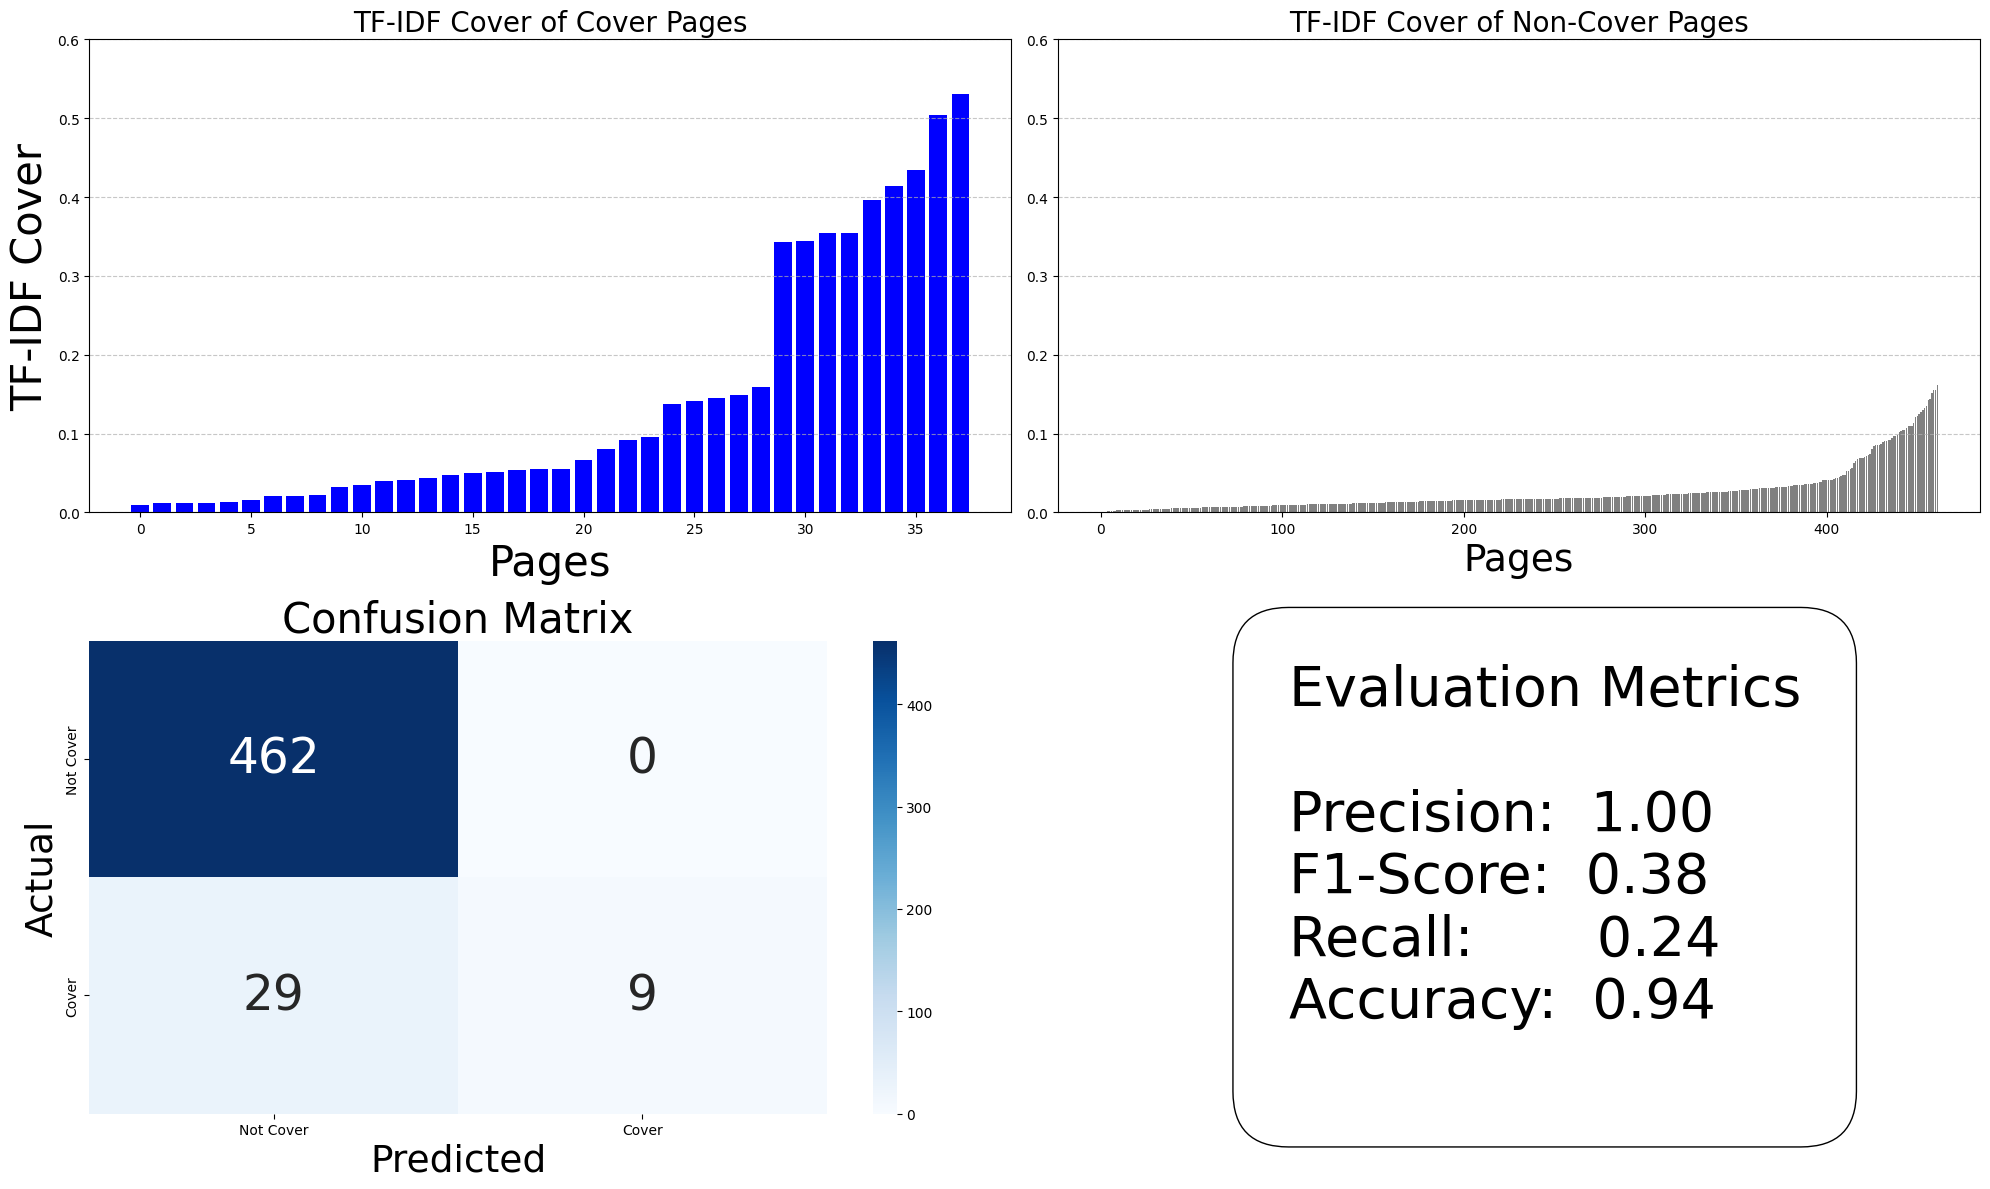

In [204]:
# load reference cover
with open('references/reference_cover.txt', 'r') as f:
    reference_cover = f.read()

fps = first_pages['masked_text'].to_list()

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2, 3),            # Unigrams and Bigrams
    tokenizer=None,                # Use default tokenizer or specify your own
    preprocessor=None,             # Use default preprocessor or specify your own
)

# Create TF-IDF Vectors
all_texts = [reference_cover] + fps

vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    tokenizer=None,
    preprocessor=None
)

tfidf_matrix = vectorizer.fit_transform(all_texts)

# Compute Cosine Similarity
reference_vector = tfidf_matrix[0:1]  # reference text
fps_vectors = tfidf_matrix[1:]       # other texts

similarities = cosine_similarity(reference_vector, fps_vectors)[0]

# Visualize the Results
first_pages['tfidf_cover'] = similarities

sorted_df = first_pages.sort_values(by='tfidf_cover').reset_index(drop=True)

# Separate the dataframes
cover_df = sorted_df[sorted_df['cover'] == True]
non_cover_df = sorted_df[sorted_df['cover'] == False]

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# ----------------------------
# Top Left: Plot for Cover Pages
# ----------------------------
axes[0, 0].bar(
    x=range(len(cover_df)),                  # X-axis: Sequential numbers
    height=cover_df['tfidf_cover'],          # Y-axis: tfidf_cover values
    color='blue'                              # Bar color
)
axes[0, 0].set_title('TF-IDF Cover of Cover Pages', fontsize=20)
axes[0, 0].set_xlabel('Pages', fontsize=30)
axes[0, 0].set_ylabel('TF-IDF Cover', fontsize=30)
axes[0, 0].set_ylim(0, 0.6)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
# Add horizontal line at y = threshold

# ----------------------------
# Top Right: Plot for Non-Cover Pages
# ----------------------------
axes[0, 1].bar(
    x=range(len(non_cover_df)),              # X-axis: Sequential numbers
    height=non_cover_df['tfidf_cover'],      # Y-axis: tfidf_cover values
    color='grey'                              # Bar color
)
axes[0, 1].set_title('TF-IDF Cover of Non-Cover Pages', fontsize=20)
axes[0, 1].set_xlabel('Pages', fontsize=27)
axes[0, 1].set_ylim(0, 0.6)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# ----------------------------
# Bottom Left: Confusion Matrix
# ----------------------------
# Create a new column 'predicted_cover' based on the threshold
first_pages['predicted_cover'] = first_pages['tfidf_cover'] >= threshold

# Compute confusion matrix
cm = confusion_matrix(first_pages['cover'], first_pages['predicted_cover'])

# Define labels
labels = ['Not Cover', 'Cover']

# Create a DataFrame for better readability in the plot
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the confusion matrix
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            annot_kws={"size": 35})
axes[1, 0].set_title('Confusion Matrix', fontsize=30)
axes[1, 0].set_ylabel('Actual', fontsize=27)
axes[1, 0].set_xlabel('Predicted', fontsize=27)


# ----------------------------
# Bottom Right: Metrics Text
# ----------------------------
# Calculate metrics
accuracy = accuracy_score(first_pages['cover'], first_pages['predicted_cover'])
precision = precision_score(first_pages['cover'], first_pages['predicted_cover'], zero_division=0)
recall = recall_score(first_pages['cover'], first_pages['predicted_cover'], zero_division=0)
f1 = f1_score(first_pages['cover'], first_pages['predicted_cover'], zero_division=0)

# Prepare the metrics text
metrics_text = (
    f"Evaluation Metrics\n\n"  
    f"Precision:  {precision:.2f}\n"
    f"F1-Score:  {f1:.2f}\n"
    f"Recall:       {recall:.2f}\n"
    f"Accuracy:  {accuracy:.2f}\n"

)

# Hide the axes for the text plot
axes[1, 1].axis('off')

# Add the text to the plot
axes[1, 1].text(0.25, 0.5, metrics_text, 
               horizontalalignment='left', 
               verticalalignment='center', 
               fontsize=40, 
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

# ----------------------------
# Final Adjustments
# ----------------------------
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

# drop predicted_cover
first_pages = first_pages.drop(columns='predicted_cover')



## Examine False Negatives

In [205]:
for  i, p in first_pages[(first_pages['cover'] == True)&(first_pages['tfidf_cover']<0.2)].iterrows():
    print(i)
    print(p['clean_text'])
    print()
    print(p['masked_text'])
    print('-------------------')

60
table of contents
indicate by check mark whether the registrant is a shell company (as defined in rule 12b 2 of the act). yes ☐ or no ☒. the aggregate market value on july 2, 2023 (the last business day of the company’s most recently completed second quarter) of the voting common stock held by nonaffiliates of the registrant, computed by reference to the closing price of the stock on that date, was approximately $8,933,575,963. the registrant does not have non voting common stock outstanding.
the number of shares of common stock outstanding as of february 13, 2024 was 138,791,480.
documents incorporated by reference
portions of our definitive proxy statement for our 2024 annual meeting of shareholders are incorporated by reference into part iii of this report.

table contents indicate check mark whether registrant shell company defined rule 12b 2 act yes aggregate market value july 2 2023 last business day company recently completed second quarter voting common stock held nonaffilia

## Table of Contents

In [206]:
threshold = 0.05
ttoc = threshold

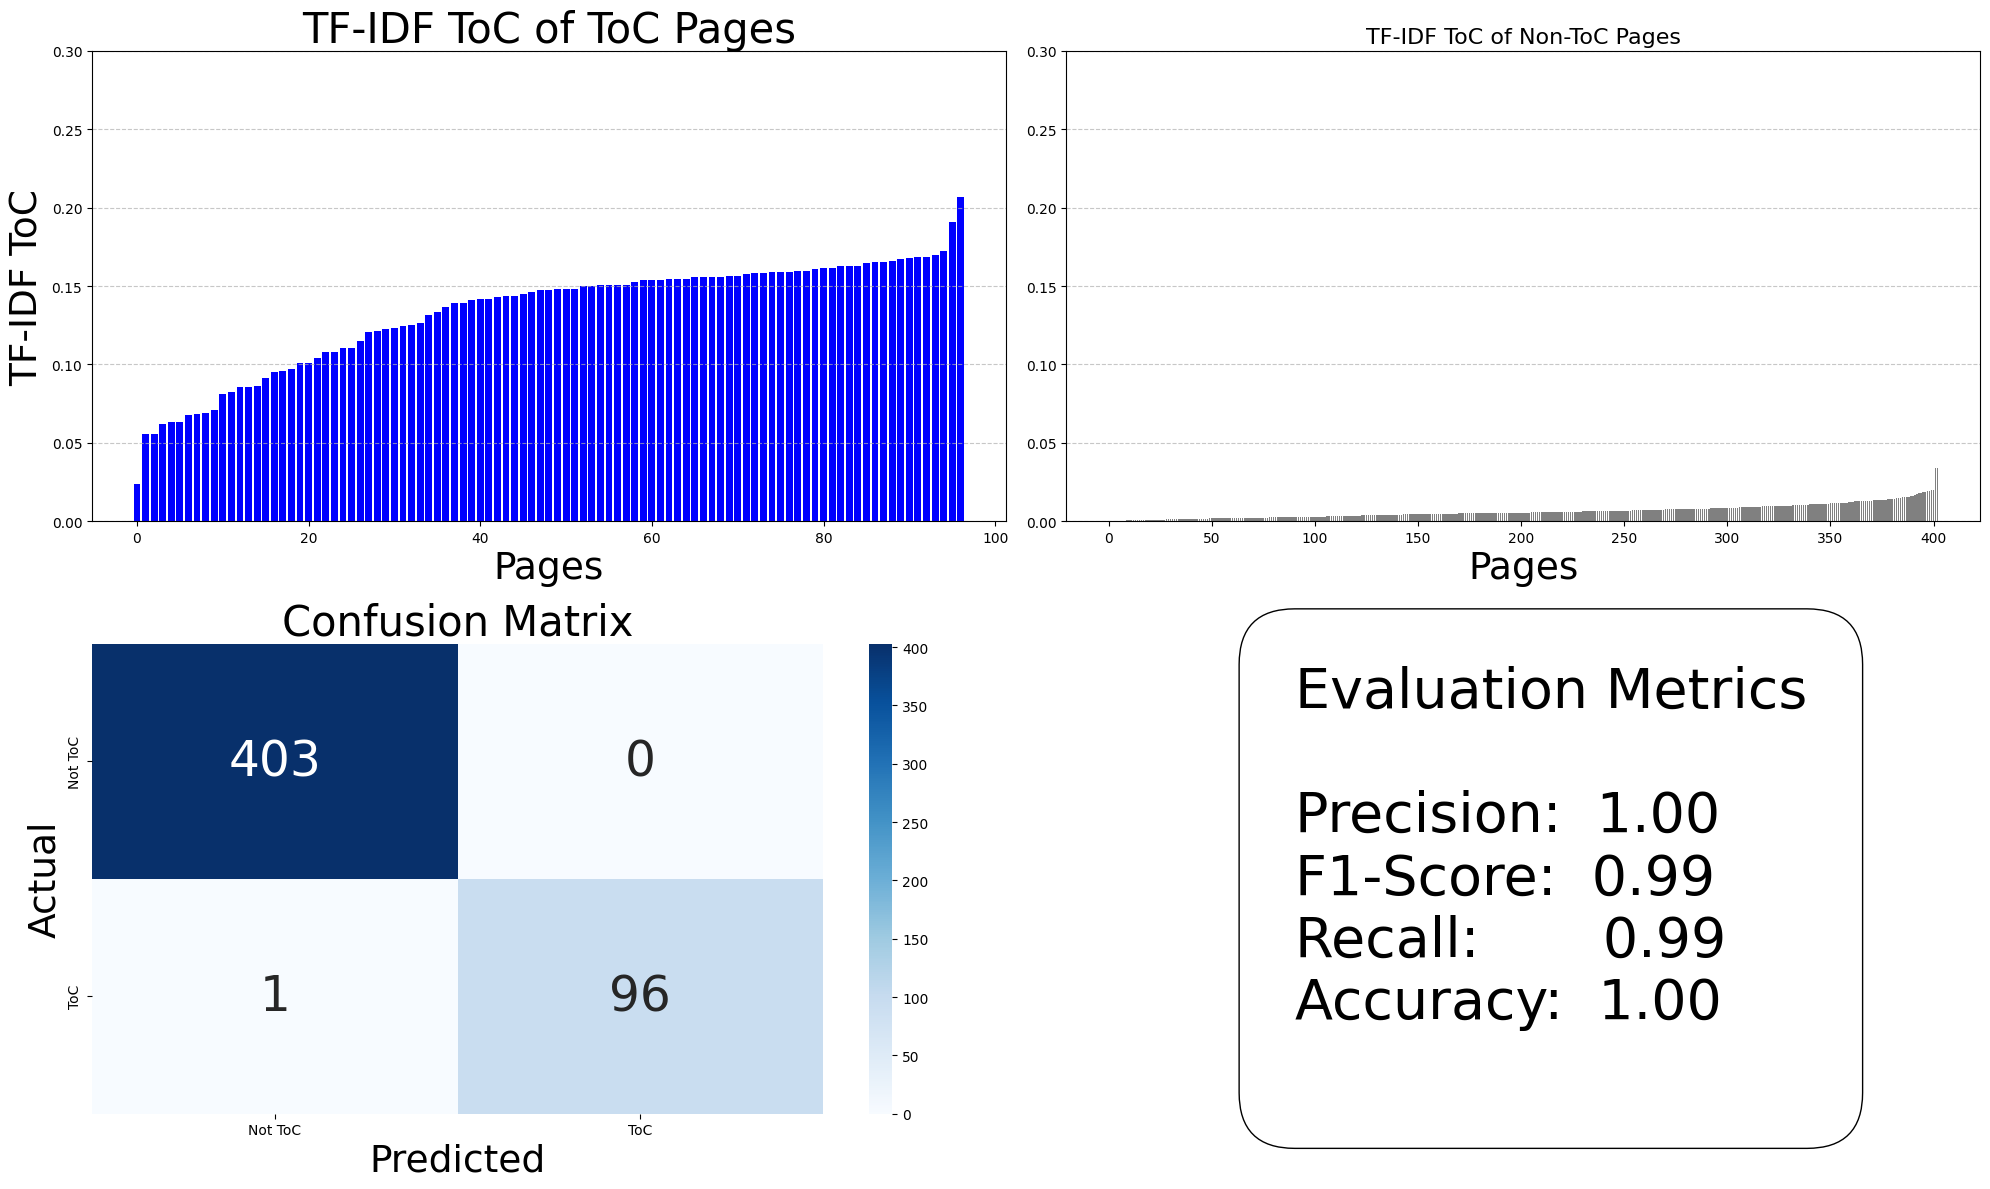

In [207]:
# load reference cover
with open('references/reference_toc.txt', 'r') as f:
    reference_toc = f.read()

fps = first_pages['masked_text'].to_list()

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2, 3),            # Unigrams and Bigrams
    tokenizer=None,                # Use default tokenizer or specify your own
    preprocessor=None,             # Use default preprocessor or specify your own
)

# Create TF-IDF Vectors
all_texts = [reference_toc] + fps

vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    tokenizer=None,
    preprocessor=None
)

tfidf_matrix = vectorizer.fit_transform(all_texts)

# Compute Cosine Similarity
reference_vector = tfidf_matrix[0:1]  # reference text
fps_vectors = tfidf_matrix[1:]       # other texts

similarities = cosine_similarity(reference_vector, fps_vectors)[0]

# Visualize the Results
first_pages['tfidf_toc'] = similarities

sorted_df = first_pages.sort_values(by='tfidf_toc').reset_index(drop=True)

# Separate the dataframes
toc_df = sorted_df[sorted_df['toc'] == True]
non_toc_df = sorted_df[sorted_df['toc'] == False]

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# ----------------------------
# Top Left: Plot for Toc Pages
# ----------------------------
axes[0, 0].bar(
    x=range(len(toc_df)),                  # X-axis: Sequential numbers
    height=toc_df['tfidf_toc'],          # Y-axis: tfidf_toc values
    color='blue'                              # Bar color
)
axes[0, 0].set_title('TF-IDF ToC of ToC Pages', fontsize=30)
axes[0, 0].set_xlabel('Pages', fontsize=27)
axes[0, 0].set_ylabel('TF-IDF ToC', fontsize=27)
axes[0, 0].set_ylim(0, 0.3)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# ----------------------------
# Top Right: Plot for Non-ToC Pages
# ----------------------------
axes[0, 1].bar(
    x=range(len(non_toc_df)),              # X-axis: Sequential numbers
    height=non_toc_df['tfidf_toc'],      # Y-axis: tfidf_toc values
    color='grey'                              # Bar color
)
axes[0, 1].set_title('TF-IDF ToC of Non-ToC Pages', fontsize=16)
axes[0, 1].set_xlabel('Pages', fontsize=27)
axes[0, 1].set_ylim(0, 0.3)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# ----------------------------
# Bottom Left: Confusion Matrix
# ----------------------------
# Create a new column 'predicted_toc' based on the threshold
first_pages['predicted_toc'] = first_pages['tfidf_toc'] >= threshold

# Compute confusion matrix
cm = confusion_matrix(first_pages['toc'], first_pages['predicted_toc'])

# Define labels
labels = ['Not ToC', 'ToC']

# Create a DataFrame for better readability in the plot
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the confusion matrix
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            annot_kws={"size": 35})
axes[1, 0].set_title('Confusion Matrix', fontsize=30)
axes[1, 0].set_ylabel('Actual', fontsize=27)
axes[1, 0].set_xlabel('Predicted', fontsize=27)

# ----------------------------
# Bottom Right: Metrics Text
# ----------------------------
# Calculate metrics
accuracy = accuracy_score(first_pages['toc'], first_pages['predicted_toc'])
precision = precision_score(first_pages['toc'], first_pages['predicted_toc'], zero_division=0)
recall = recall_score(first_pages['toc'], first_pages['predicted_toc'], zero_division=0)
f1 = f1_score(first_pages['toc'], first_pages['predicted_toc'], zero_division=0)

# Prepare the metrics text
metrics_text = (
    f"Evaluation Metrics\n\n"  
    f"Precision:  {precision:.2f}\n"
    f"F1-Score:  {f1:.2f}\n"
    f"Recall:       {recall:.2f}\n"
    f"Accuracy:  {accuracy:.2f}\n"

)

# Hide the axes for the text plot
axes[1, 1].axis('off')

# Add the text to the plot
axes[1, 1].text(0.25, 0.5, metrics_text, 
               horizontalalignment='left', 
               verticalalignment='center', 
               fontsize=40, 
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

# ----------------------------
# Final Adjustments
# ----------------------------
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

# drop predicted_toc
first_pages = first_pages.drop(columns='predicted_toc')



## Examine False Negatives

In [208]:
for  i, p in first_pages[(first_pages['toc'] == True)&(first_pages['tfidf_toc']<0.05)].iterrows():
    print(i)
    print(p['clean_text'])
    print()
    print(p['masked_text'])
    print('-------------------')


125
table of contents
item page no.
part i
[1.](https://www.sec.gov/archives/edgar/data/93410/000009341013000003/cvx 123112x10kdoc.htm s60351102) business 3
general development of business 3
description of business and properties 4
capital and exploratory expenditures 4
upstream 4
[downstream](https://www.sec.gov/archives/edgar/data/93410/000009341013000003/cvx 123112x10kdoc.htm snull) 24
[other businesses](https://www.sec.gov/archives/edgar/data/93410/000009341013000003/cvx 123112x10kdoc.htm snull) 26
web site access to sec reports 28
1a. risk factors 28
1b. unresolved staff comments 30
[2.](https://www.sec.gov/archives/edgar/data/93410/000009341013000003/cvx 123112x10kdoc.htm s60351131) [properties](https://www.sec.gov/archives/edgar/data/93410/000009341013000003/cvx 123112x10kdoc.htm s60351131) 30
[3.](https://www.sec.gov/archives/edgar/data/93410/000009341013000003/cvx 123112x10kdoc.htm s60351132) [legal proceedings](https://www.sec.gov/archives/edgar/data/93410/000009341013000003/

### Examine False Positives

In [209]:
for  i, p in first_pages[(first_pages['toc'] == False)&(first_pages['tfidf_toc']>=0.05)].iterrows():
    print(i)
    print(p['clean_text'])
    print()
    print(p['masked_text'])
    print('-------------------')

# CORRECTION SECTION TO DELETE

In [210]:
# # # open first_pages
# fp = pd.read_parquet('labelled/first_pages_labelled.parquet')

# i = 164
# print(fp.loc[i]['doc_id'])
# print(fp.loc[i]['toc'])
# print(fp.loc[i]['clean_text'])
# # # change the value of toc to True
# # fp.at[i, 'toc'] = False

# # # # # save the updated dataframe
# # fp.to_parquet('labelled/first_pages_labelled.parquet')

# Embeddings

In [211]:
with io.open('/Users/emanueleferrari/desktop/Key.txt', 'r', encoding='utf-8') as file:
        api_key = file.read().strip()

os.environ['OPENAI_API_KEY'] = api_key
del api_key

client = OpenAI()


In [212]:
def get_embedding(text, model="text-embedding-3-small"):
   return client.embeddings.create(input = [text], model=model).data[0].embedding

def get_embeddings(df, model="text-embedding-3-small"):
   df = df.copy()
   embeddings = []
   for text in tqdm(df['masked_text'], desc='Getting embeddings'):
      embeddings.append(get_embedding(text, model=model))
   df['emb'] = embeddings
   return df


In [213]:
def geometric_median(points, max_iter=1000, tol=1e-7):
    """
    Compute the geometric median of a set of points in R^D using Weiszfeld's algorithm.
    
    Parameters:
    - points: array-like, shape (N, D)
        A set of N points in D-dimensional space.
    - max_iter: int, default=1000
        Maximum number of iterations.
    - tol: float, default=1e-7
        Tolerance for convergence.
        
    Returns:
    - median: ndarray, shape (D,)
        The geometric median of the input points.
    """
    # Convert input to NumPy array
    points = np.asarray(points)
    
    # Ensure points is 2D
    if points.ndim == 1:
        points = points.reshape(-1, 1)
    elif points.ndim != 2:
        raise ValueError("Input points must be a 1D or 2D array.")
    
    # Start guess: the centroid (arithmetic mean)
    current = np.mean(points, axis=0)
    
    for i in range(max_iter):
        # Compute distances from current guess to all points
        distances = np.linalg.norm(points - current, axis=1)
        
        # To avoid division by zero, handle points that coincide with current
        mask_nonzero = distances != 0
        if not np.any(mask_nonzero):
            # All points coincide with the current guess
            return current
        
        # Compute weights: inverse of distances
        weights = np.zeros_like(distances)
        weights[mask_nonzero] = 1.0 / distances[mask_nonzero]
        
        # Compute the weighted sum of points
        numerator = (points.T * weights).sum(axis=1)
        denominator = weights.sum()
        
        # Update the current guess
        new_current = numerator / denominator
        
        # Check for convergence
        shift = np.linalg.norm(new_current - current)
        if shift < tol:
            return new_current
        
        current = new_current
    
    return current

def plot_histogram(ax, data, threshold, colors, title, xlabel, ylabel, bins, range_min, range_max):
    # Calculate histogram data
    counts, bin_edges = np.histogram(data, bins=bins, range=(range_min, range_max))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Assign colors based on bin centers
    bin_colors = [colors['below'] if center < threshold else colors['above'] for center in bin_centers]

    # Width of each bin
    bin_width = bin_edges[1] - bin_edges[0]

    # Plot bars
    ax.bar(bin_centers, counts, width=bin_width, color=bin_colors, alpha=0.7, edgecolor='black')

    # Add vertical line at threshold
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2)

    # Set titles and labels
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)


## Get Embeddings

In [214]:
# first_pages = get_embeddings(first_pages)

# save first_pages as first_pages_emb
# first_pages.to_parquet('labelled/first_pages_emb.parquet') 


# load first_pages
first_pages = pd.read_parquet('labelled/first_pages_emb.parquet')
# first_pages.head()

## Load References

In [215]:
# emb_cover = first_pages[first_pages['cover']]['emb'].to_list()

# centroid_cover = np.mean(emb_cover, axis=0)
# median_cover = geometric_median(emb_cover)

# print("Cover centroid:", centroid_cover)
# print("Cover median:", median_cover)

# # save the centroid and median
# np.save('references/centroid_cover.npy', centroid_cover)
# np.save('references/median_cover.npy', median_cover)

# emb_toc = first_pages[first_pages['toc']]['emb'].to_list()

# centroid_toc = np.mean(emb_toc, axis=0)
# median_toc = geometric_median(emb_toc)

# print("ToC centroid:", centroid_toc)
# print("ToC median:", median_toc)

# # save the centroid and median
# np.save('references/centroid_toc.npy', centroid_toc)
# np.save('references/median_toc.npy', median_toc)

# load centroid and median
centroid_cover = np.load('references/centroid_cover.npy')
median_cover = np.load('references/median_cover.npy')
centroid_toc = np.load('references/centroid_toc.npy')
median_toc = np.load('references/median_toc.npy')


## Cover Page

In [216]:
threshold = 0.82
tcp = threshold

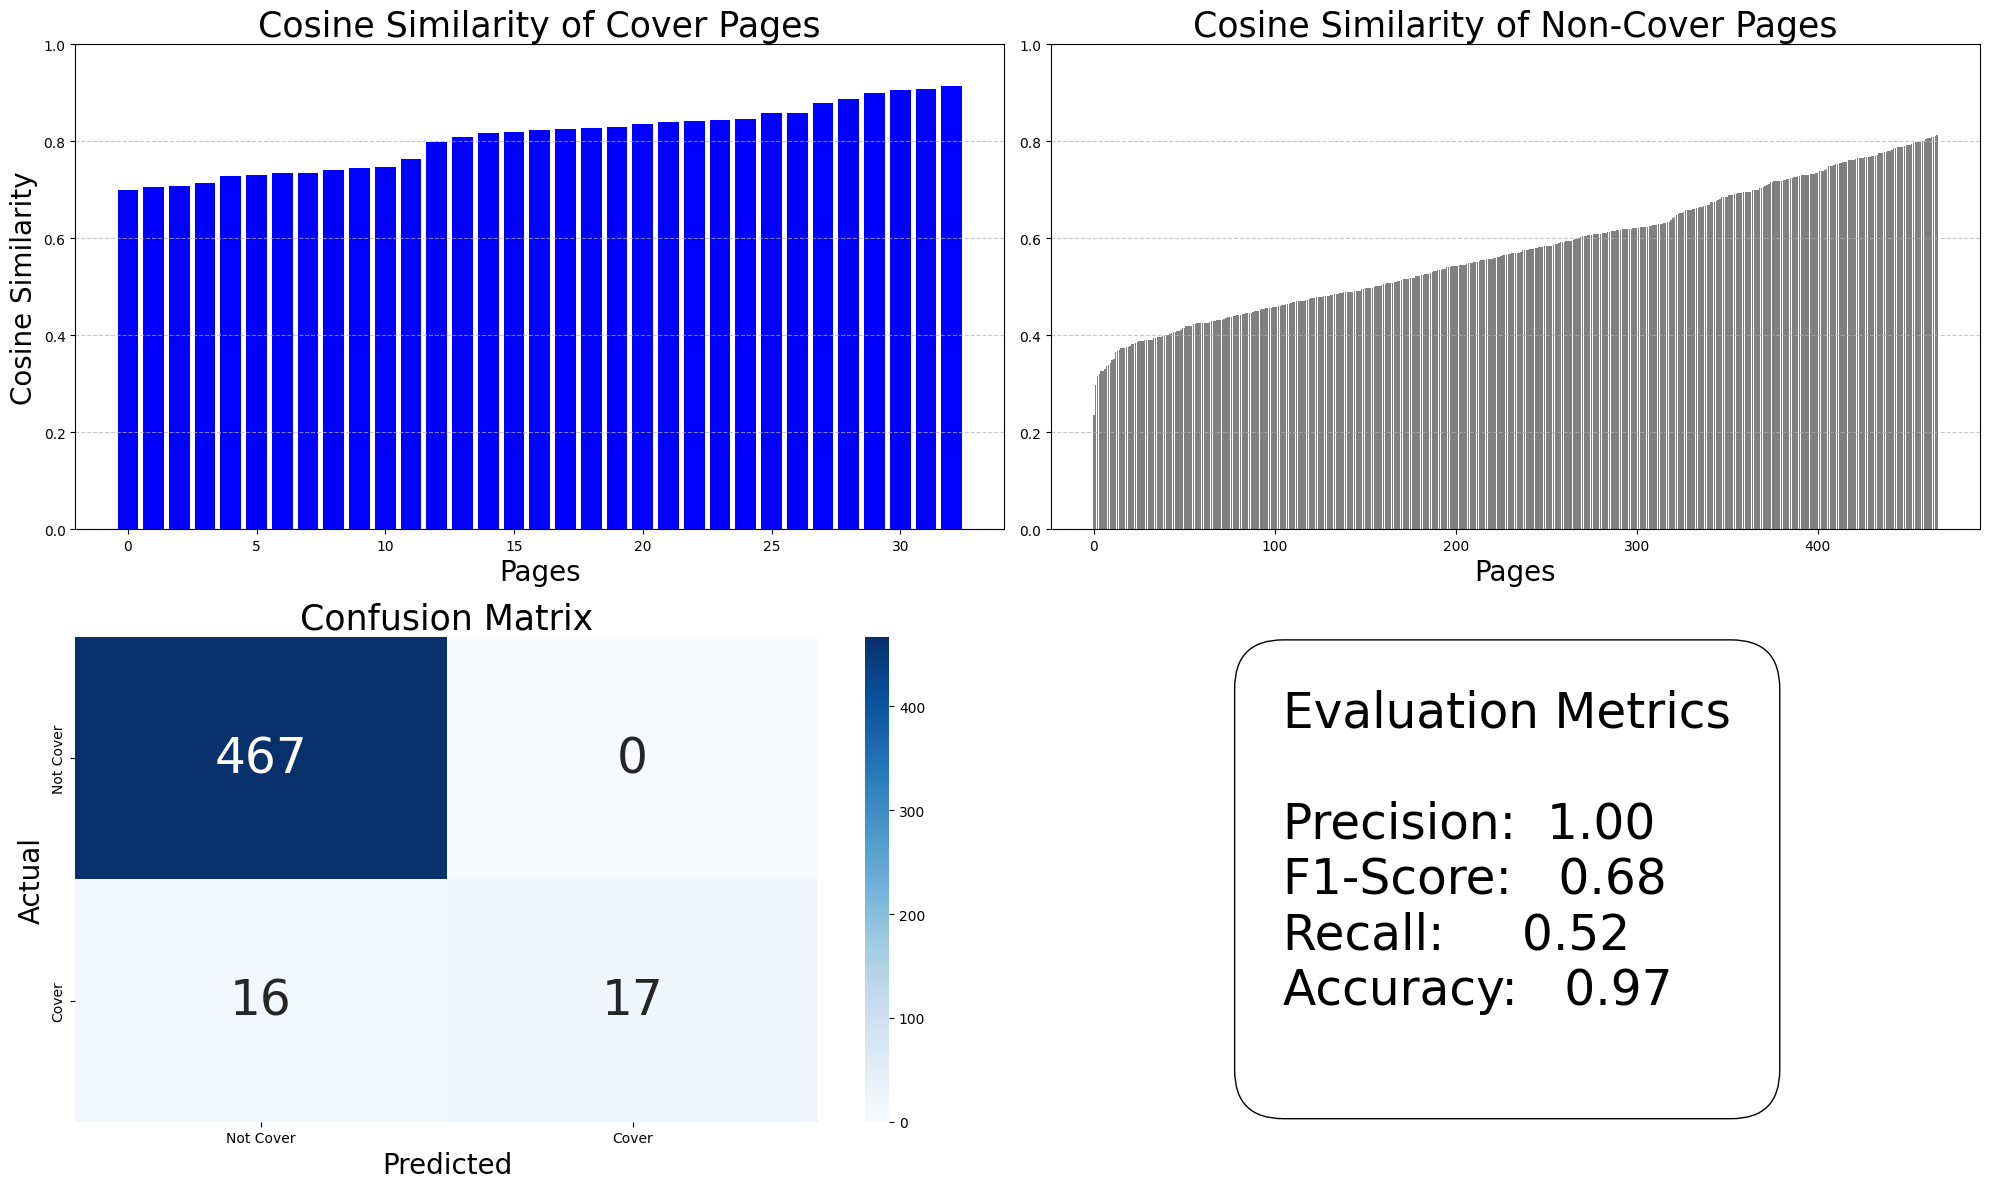

In [217]:
# 1) Compute 'emb_sim_cover' using centroid_cover

cover_centroid_array = np.array(centroid_cover).reshape(1, -1)  # shape (1, embedding_dim)
emb_array = np.stack(first_pages['emb'].to_numpy())             # shape (n_samples, embedding_dim)

# Calculate cosine similarity for each row to cover centroid
similarities = pairwise.cosine_similarity(emb_array, cover_centroid_array)
first_pages['emb_sim_cover'] = similarities.ravel()  # Flatten to 1D

# ------------------------------------------------
# 2) Split into COVER and NON-COVER subsets
# ------------------------------------------------
cover_df = first_pages[first_pages['cover'] == True].sort_values(by='emb_sim_cover')
non_cover_df = first_pages[first_pages['cover'] == False].sort_values(by='emb_sim_cover')

# ------------------------------------------------
# 3) Create a binary prediction using a threshold
# ------------------------------------------------
cover_threshold = threshold
first_pages['predicted_cover'] = first_pages['emb_sim_cover'] >= cover_threshold

# ------------------------------------------------
# 4) Create a 2x2 subplot grid for visualization
# ------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# ----------------------------
# Top Left: Plot for Cover Pages
# ----------------------------
axes[0, 0].bar(
    x=range(len(cover_df)),                          
    height=cover_df['emb_sim_cover'],               
    color='blue'                                    
)
axes[0, 0].set_title('Cosine Similarity of Cover Pages', fontsize=25)
axes[0, 0].set_xlabel('Pages', fontsize=20)
axes[0, 0].set_ylabel('Cosine Similarity', fontsize=20)
axes[0, 0].set_ylim(0, 1)  # typical cos-sim range is [-1,1], adjust as needed
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# ----------------------------
# Top Right: Plot for Non-Cover Pages
# ----------------------------
axes[0, 1].bar(
    x=range(len(non_cover_df)),                    
    height=non_cover_df['emb_sim_cover'],          
    color='grey'                                   
)
axes[0, 1].set_title('Cosine Similarity of Non-Cover Pages', fontsize=25)
axes[0, 1].set_xlabel('Pages', fontsize=20)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# ----------------------------
# Bottom Left: Confusion Matrix
# ----------------------------
cm = confusion_matrix(first_pages['cover'], first_pages['predicted_cover'])
labels = ['Not Cover', 'Cover']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

sns.heatmap(
    cm_df, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    ax=axes[1, 0],
    annot_kws={"size": 35}
)
axes[1, 0].set_title('Confusion Matrix', fontsize=25)
axes[1, 0].set_ylabel('Actual', fontsize=20)
axes[1, 0].set_xlabel('Predicted', fontsize=20)

# ----------------------------
# Bottom Right: Metrics Text
# ----------------------------
accuracy = accuracy_score(first_pages['cover'], first_pages['predicted_cover'])
precision = precision_score(first_pages['cover'], first_pages['predicted_cover'], zero_division=0)
recall = recall_score(first_pages['cover'], first_pages['predicted_cover'], zero_division=0)
f1 = f1_score(first_pages['cover'], first_pages['predicted_cover'], zero_division=0)

metrics_text = (
    f"Evaluation Metrics\n\n"  
    f"Precision:  {precision:.2f}\n"
    f"F1-Score:   {f1:.2f}\n"
    f"Recall:     {recall:.2f}\n"
    f"Accuracy:   {accuracy:.2f}\n"
)

axes[1, 1].axis('off')
axes[1, 1].text(
    0.25, 0.5, 
    metrics_text, 
    horizontalalignment='left', 
    verticalalignment='center', 
    fontsize=35, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
)

plt.tight_layout()
plt.show()

# ---------------------------------------
# (Optional) Drop the predicted_cover column
# ---------------------------------------
first_pages.drop(columns='predicted_cover', inplace=True)


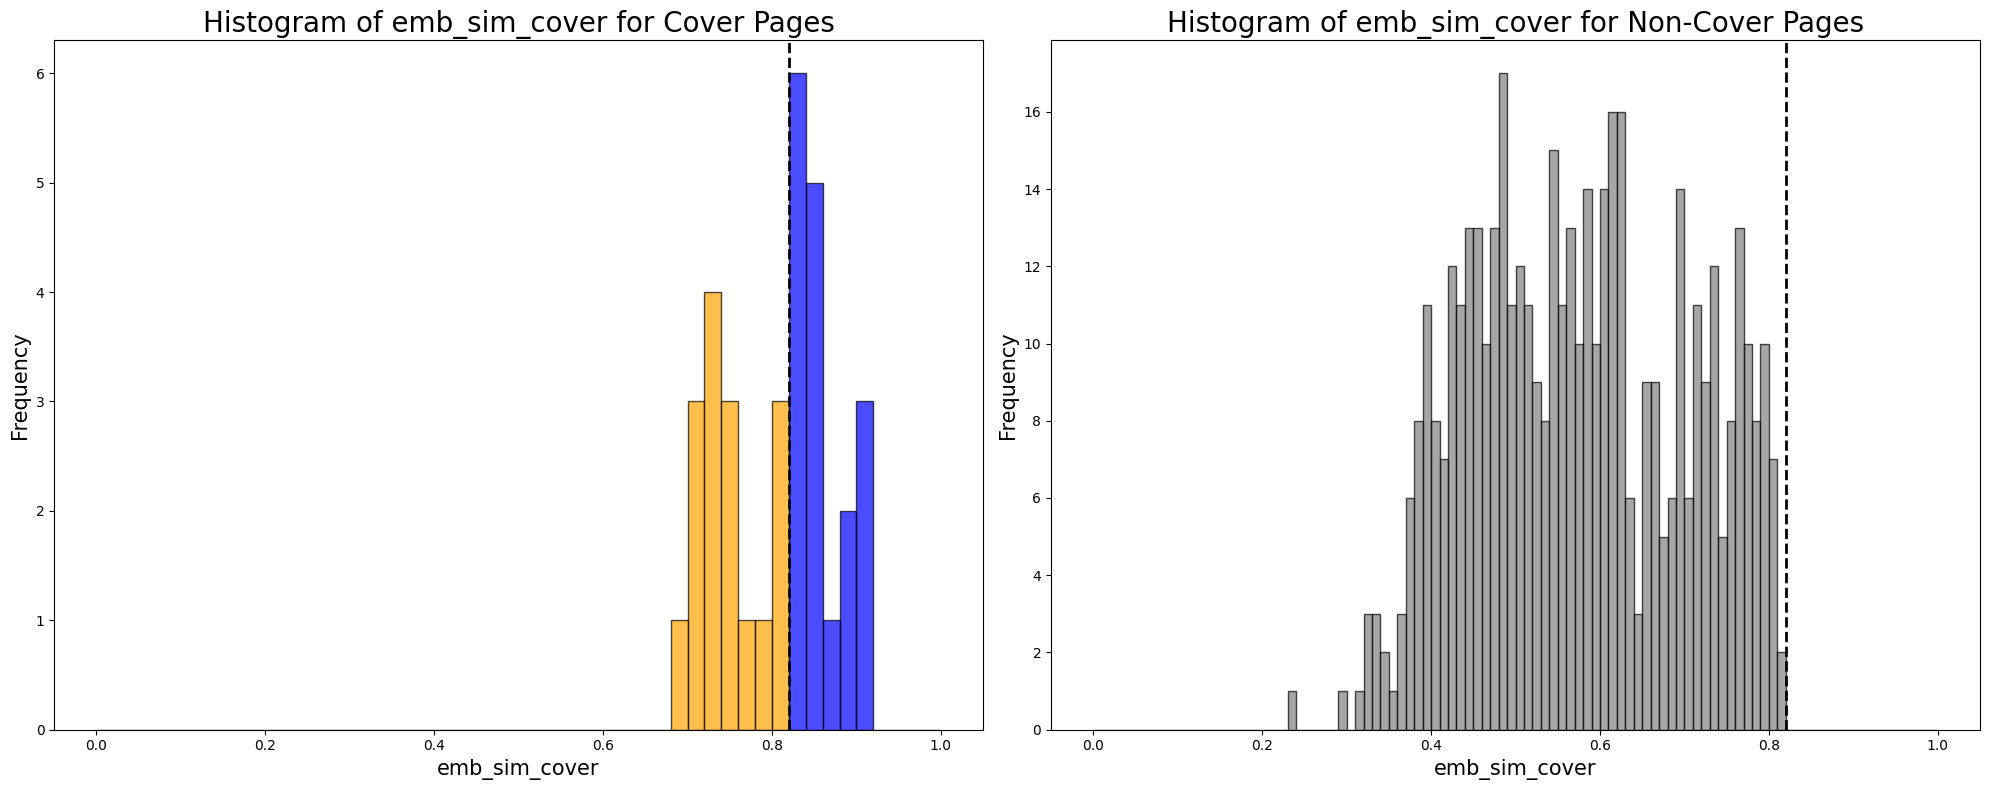

In [218]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Filter and sort data
cover_df = first_pages[first_pages['cover'] == True].sort_values(by='emb_sim_cover')
non_cover_df = first_pages[first_pages['cover'] == False].sort_values(by='emb_sim_cover')

# Define color schemes
cover_colors = {'below': 'orange', 'above': 'blue'}
non_cover_colors = {'below': 'grey', 'above': 'red'}

# Plot for Cover Pages (cover == True)
plot_histogram(
    ax=axes[0],
    data=cover_df['emb_sim_cover'],
    threshold=threshold,
    colors=cover_colors,
    title='Histogram of emb_sim_cover for Cover Pages',
    xlabel='emb_sim_cover',
    ylabel='Frequency',
    bins=50,
    range_min=0,
    range_max=1
)

bins = 100
# Plot for Non-Cover Pages (cover == False)
plot_histogram(
    ax=axes[1],
    data=non_cover_df['emb_sim_cover'],
    threshold=threshold,
    colors=non_cover_colors,
    title='Histogram of emb_sim_cover for Non-Cover Pages',
    xlabel='emb_sim_cover',
    ylabel='Frequency',
    bins=100,
    range_min=0,
    range_max=1
)

# Adjust layout and display
plt.tight_layout()
plt.show()


### Analyze False Negatives

In [219]:
for  i, p in first_pages[(first_pages['cover'] == True)&(first_pages['emb_sim_cover']<threshold)].iterrows():
    print(i)
    print(p['clean_text'])
    print()
    print(p['masked_text'])
    print('-------------------')

70
class number of shares outstanding date
common stock 11,963,137 december 31, 2014
common stock non voting 116,305,343 december 31, 2014
documents incorporated by reference
document part of 10 k into which incorporated
proxy statement for mccormick’s march 25, 2015 annual meeting of stockholders
(the “2015 proxy statement”) part iii

class number shares outstanding date common stock 11 963 137 december 31 2014 common stock non voting 116 305 343 december 31 2014 documents incorporated reference document part 10 k incorporated proxy statement mccormick march 25 2015 annual meeting stockholders 2015 proxy statement part iii
-------------------
181
cautionary statements
unless otherwise indicated or except where the context otherwise requires, the terms “we,” “us,” “our,” “company” and other similar terms in this annual report on form 10 k (the
“annual report”) refer to ventas, inc. and its consolidated subsidiaries.
forward looking statements
this annual report includes forward looking

## Table of Contents

In [220]:
threshold = 0.76

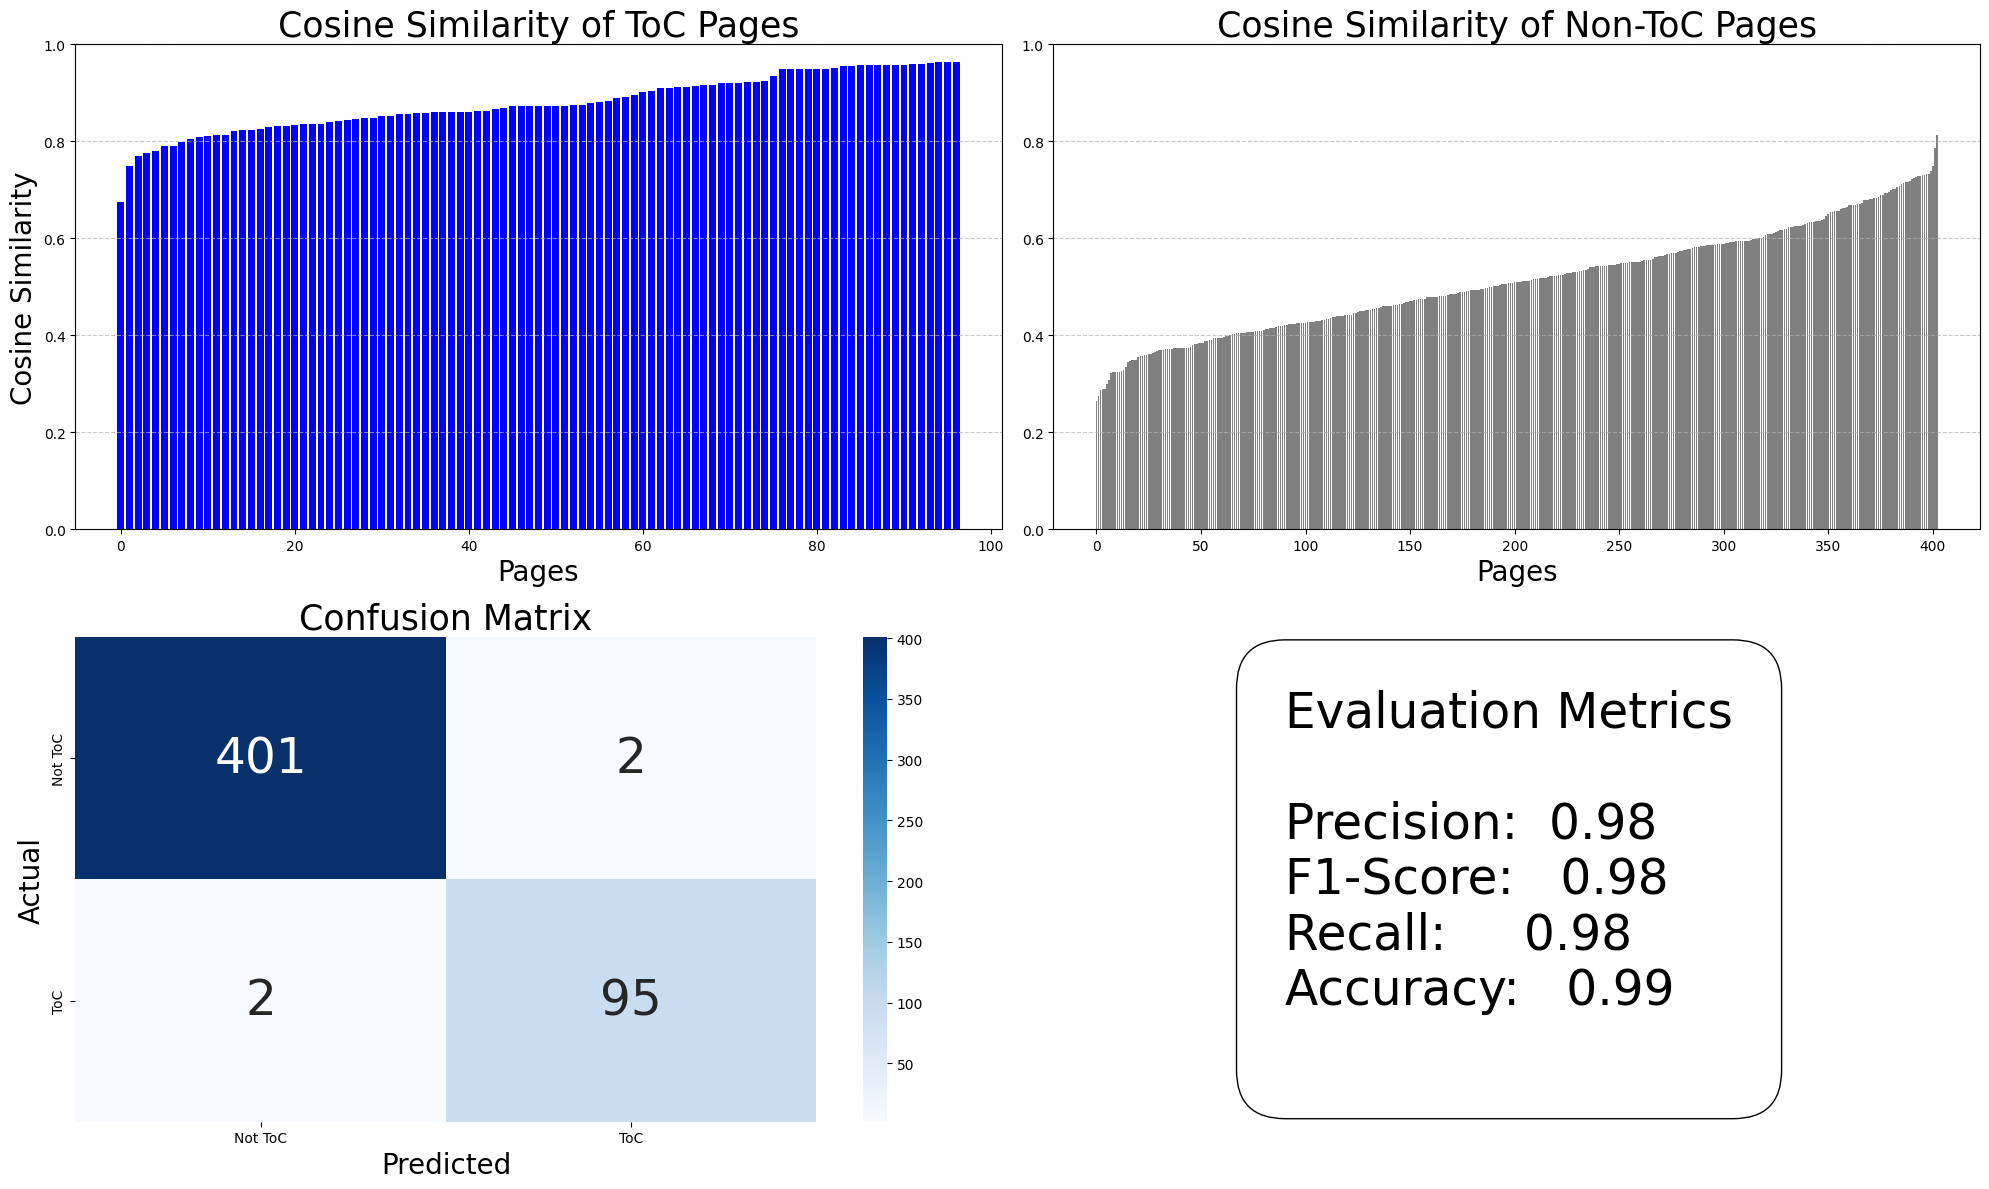

In [221]:
# 1) Compute 'emb_sim_toc' using centroid_toc
# ------------------------------------------------
toc_centroid_array = np.array(centroid_toc).reshape(1, -1)  # shape (1, embedding_dim)
emb_array = np.stack(first_pages['emb'].to_numpy())         # shape (n_samples, embedding_dim)

# Calculate cosine similarity for each row to toc centroid
similarities = pairwise.cosine_similarity(emb_array, toc_centroid_array)
first_pages['emb_sim_toc'] = similarities.ravel()

# ------------------------------------------------
# 2) Split into TOC and NON-TOC subsets
# ------------------------------------------------
toc_df = first_pages[first_pages['toc'] == True].sort_values(by='emb_sim_toc')
non_toc_df = first_pages[first_pages['toc'] == False].sort_values(by='emb_sim_toc')

# ------------------------------------------------
# 3) Create a binary prediction using a threshold
# ------------------------------------------------
# You can adjust this threshold based on your data
toc_threshold = threshold
first_pages['predicted_toc'] = first_pages['emb_sim_toc'] >= toc_threshold

# ------------------------------------------------
# 4) Create a 2x2 subplot grid for visualization
# ------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# ----------------------------
# Top Left: Plot for ToC Pages
# ----------------------------
axes[0, 0].bar(
    x=range(len(toc_df)),                          
    height=toc_df['emb_sim_toc'],                 
    color='blue'                                   
)
axes[0, 0].set_title('Cosine Similarity of ToC Pages', fontsize=25)
axes[0, 0].set_xlabel('Pages', fontsize=20)
axes[0, 0].set_ylabel('Cosine Similarity', fontsize=20)
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# ----------------------------
# Top Right: Plot for Non-ToC Pages
# ----------------------------
axes[0, 1].bar(
    x=range(len(non_toc_df)),                    
    height=non_toc_df['emb_sim_toc'],           
    color='grey'                                 
)
axes[0, 1].set_title('Cosine Similarity of Non-ToC Pages', fontsize=25)
axes[0, 1].set_xlabel('Pages', fontsize=20)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# ----------------------------
# Bottom Left: Confusion Matrix
# ----------------------------
cm = confusion_matrix(first_pages['toc'], first_pages['predicted_toc'])
labels = ['Not ToC', 'ToC']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

sns.heatmap(
    cm_df, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    ax=axes[1, 0],
    annot_kws={"size": 35}
)
axes[1, 0].set_title('Confusion Matrix', fontsize=25)
axes[1, 0].set_ylabel('Actual', fontsize=20)
axes[1, 0].set_xlabel('Predicted', fontsize=20)

# ----------------------------
# Bottom Right: Metrics Text
# ----------------------------
accuracy = accuracy_score(first_pages['toc'], first_pages['predicted_toc'])
precision = precision_score(first_pages['toc'], first_pages['predicted_toc'], zero_division=0)
recall = recall_score(first_pages['toc'], first_pages['predicted_toc'], zero_division=0)
f1 = f1_score(first_pages['toc'], first_pages['predicted_toc'], zero_division=0)

metrics_text = (
    f"Evaluation Metrics\n\n"  
    f"Precision:  {precision:.2f}\n"
    f"F1-Score:   {f1:.2f}\n"
    f"Recall:     {recall:.2f}\n"
    f"Accuracy:   {accuracy:.2f}\n"
)

axes[1, 1].axis('off')
axes[1, 1].text(
    0.25, 0.5, 
    metrics_text, 
    horizontalalignment='left', 
    verticalalignment='center', 
    fontsize=35, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
)

plt.tight_layout()
plt.show()

# ------------------------------------
# (Optional) Drop the predicted_toc column
# ------------------------------------
first_pages.drop(columns='predicted_toc', inplace=True)


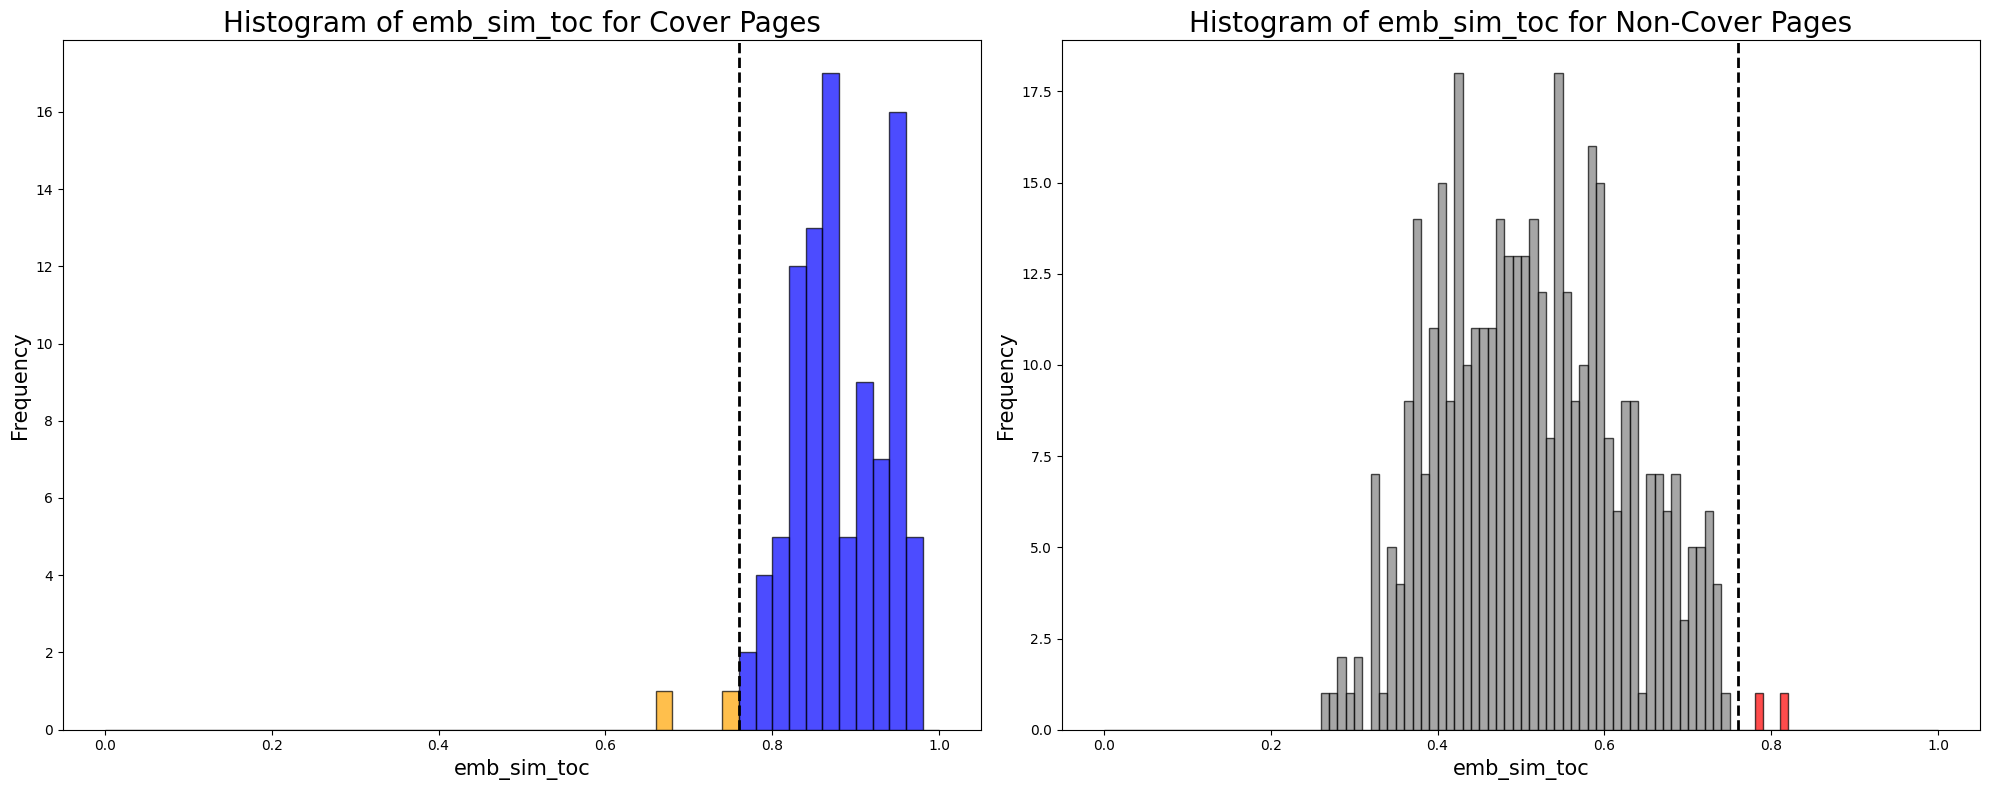

In [222]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Filter and sort data
toc_df = first_pages[first_pages['toc'] == True].sort_values(by='emb_sim_toc')
non_toc_df = first_pages[first_pages['toc'] == False].sort_values(by='emb_sim_toc')

# Define color schemes
cover_colors = {'below': 'orange', 'above': 'blue'}
non_cover_colors = {'below': 'grey', 'above': 'red'}

# Plot for Cover Pages (cover == True)
plot_histogram(
    ax=axes[0],
    data=toc_df['emb_sim_toc'],
    threshold=threshold,
    colors=cover_colors,
    title='Histogram of emb_sim_toc for Cover Pages',
    xlabel='emb_sim_toc',
    ylabel='Frequency',
    bins=50,
    range_min=0,
    range_max=1
)

bins = 100
# Plot for Non-Cover Pages (cover == False)
plot_histogram(
    ax=axes[1],
    data=non_toc_df['emb_sim_toc'],
    threshold=threshold,
    colors=non_cover_colors,
    title='Histogram of emb_sim_toc for Non-Cover Pages',
    xlabel='emb_sim_toc',
    ylabel='Frequency',
    bins=100,
    range_min=0,
    range_max=1
)

# Adjust layout and display
plt.tight_layout()
plt.show()


### Analyse False Positives

In [223]:
for  i, p in first_pages[(first_pages['toc'] == False)&(first_pages['emb_sim_toc']>=threshold)].iterrows():
    print(i)
    print(p['clean_text'])
    print()
    print(p['masked_text'])
    print('-------------------')

367
table of contents
to help investors understand the differences between host inc. and host l.p., this report presents the following separate sections or portions of sections for each of host inc. and host l.p.:
part ii item 5 – market for registrant’s common stock, related stockholder matters and issuer purchases of equity securities for host inc. / market for registrant’s common
units, related unitholder matters and issuer purchases of equity securities for host l.p.;
part ii item 6 – selected financial data;
part ii item 7 – management’s discussion and analysis of financial condition and results of operations is combined, except for a separate discussion of material differences, if
any, in the liquidity and capital resources between host inc. and host l.p.;
part ii item 7a – quantitative and qualitative disclosures about market risk is combined, except for separate discussions of material differences, if any, between host inc. and
host l.p.; and
part ii item 8 – consolidated finan

### Analize False Negatives

In [224]:
for  i, p in first_pages[(first_pages['toc'] == True)&(first_pages['emb_sim_toc']<threshold)].iterrows():
    print(i)
    print(p['clean_text'])
    print()
    print(p['masked_text'])
    print('-------------------')

285
gilead sciences, inc.
2020 form 10 k annual report
table of contents
part i
item 1 business 3 item 1a risk factors 16 item 1b unresolved staff comments 28 item 2 properties 28 item 3 legal proceedings 28 item 4 mine safety disclosures 28
part ii
item 5 market for registrant’s common equity, related stockholder matters and issuer purchases of equity securities 29 item 6 selected financial data 31 item 7 management’s discussion and analysis of financial condition and results of operations 32 item 7a quantitative and qualitative disclosures about market risk 48 item 8 financial statements and supplementary data 51 item 9 changes in and disagreements with accountants on accounting and financial disclosure 103 item 9a controls and procedures 105 item 9b other information 106
part iii
item 10 directors, executive officers and corporate governance 106 item 11 executive compensation 106 item 12 security ownership of certain beneficial owners and management and related stockholder matters 1

# LLM

In [225]:
class DetectionAnswerToc(BaseModel):
    reasoning: str = Field(..., description="the reasoning behind your decision, including if the page is a TOC and if it is only a fraction of the TOC")
    result: bool = Field(..., description="True if the page is a TOC or a fraction of it, False otherwise")
    

parser_toc = PydanticOutputParser(pydantic_object=DetectionAnswerToc)

class DetectionAnswerCover(BaseModel):
    reasoning: str = Field(..., description="the reasoning behind your decision, including if the page is a TOC and if it is only a fraction of the TOC")
    result: bool = Field(..., description="True if the page is a cover page or a fraction of it, False otherwise")
    

parser_cover = PydanticOutputParser(pydantic_object=DetectionAnswerCover)




## Table of Content

In [226]:
# SYSTEM PROMPT

extract_toc_system = """You are an assistans specialized in Table of Contents (TOC) detection from SEC 10-K filings.

Your task is to reason about the input and detect if a provided page is a Table of Contents page or not.

To help you with your task the page text have been clean and numbers and years masked.
Here is a reference Table of Contents page:

'''table of contents
item page number
part i
item 1 business [number]
item 1a risk factors [number]
item 1b unresolved staff comments [number]
item 1c cybersecurity [number]
item 2 properties [number]
item 3 legal proceedings [number]
item 4 mine safety disclosures [number]
part ii
item 5 market for registrant’s common equity, related stockholder matters and issuer purchases of equity securities [number]
item 6 selected financial data [number]
item 7 management’s discussion and analysis of financial condition and results of operations [number]
item 7a quantitative and qualitative disclosures about market risk [number]
item 8 financial statements and supplementary data [number]
item 9 changes in and disagreements with accountants on accounting and financial disclosure [number]
item 9a controls and procedures [number]
item 9b other information [number]
item 9c disclosure regarding foreign jurisdictions that prevent inspections [number]
part iii
item 10 directors, executive officers and corporate governance [number]
item 11 executive compensation [number]
item 12 security ownership of certain beneficial owners and management and related stockholder matters [number]
item 13 certain relationships and related transactions, and director independence [number]
item 14 principal accounting fees and services [number]
part iv
item 15 exhibits, financial statement schedules [number]
signatures [number] 
item 16 form 10-k summary [number]'''

These references are indicative; the actual text may vary slightly (company name, plurals, minor wording differences) but should remain easily recognizable as the item heading.

Important notes:
The table of contents may omit some of the item headings.
The table of contents may include other sub headings.
The table of content may be splitted in multiple pages, and only a fraction of the table may be present in the page.
The table of content may have other text block at the beginning or at the end of the page, including forward looking statements, some notes, or diclaimers. 

A common false positive (that should not be detected) is the first page where Item 1 is the headings followed by its narrative text.

You will be provided with the entire page text.

"""

In [227]:
first_pages['llm_toc'] = False

for document in tqdm(first_pages['doc_id'].unique()):
    print(f"Document ID: {document}")
    print()

    sys_messge = (SystemMessage(content=extract_toc_system + "\n" + parser_toc.get_format_instructions()))

    messages = [sys_messge]

    llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
    llm = llm.with_structured_output(DetectionAnswerToc)
        
    is_last_true = False
    any_detection = False

    for _, row in first_pages[first_pages['doc_id'] == document].iterrows():
        n = row['page_number']
        page = row['masked_text']

        if is_last_true:
            human_message = f'Previous page was a toc or a fraction of it. Is the following page the continuation of the Table of Contents? \n\n{page}'
        else:
            human_message = f'Is the following page a Table of Content or the first part of a toc? \n\n{page}'

        messages.append(HumanMessage(content=human_message))     
        response = llm.invoke(messages)

        if is_last_true and not response.result:
            print(f"Page {n} is not a TOC. Eearly stop")
            print(response.reasoning)
            print()
            break

        if response.result:
            ai_message = f'Previous page is a ToC or a frament of it. \n\nPrevious reasoning: {response.reasoning}'
            messages.append(AIMessage(content=ai_message))
            is_last_true = True
            any_detection = True
            first_pages.loc[(first_pages['doc_id'] == document) & (first_pages['page_number'] == n), 'llm_toc'] = True

            print(f"Page {n} is a TOC")
            print(response.reasoning)
            print()
        else:
            print(f"Page {n} is not a TOC")
            print(response.reasoning)
            print()
    if not any_detection:
        print("No TOC detected")

    print('~~~~~~~~~~~~~~~~~~~~')
    # for m in messages:
    #     print(type(m))
    #     print(m.content)
    #     print()
    print('-------------------')

  0%|          | 0/100 [00:00<?, ?it/s]

Document ID: tr00_0000001800_0001047469-15-001377

Page 1 is not a TOC
The page provided contains the heading 'item 1 business' followed by a detailed narrative description of the business operations of Abbott Laboratories. This indicates that the page is not a Table of Contents (TOC) but rather the beginning of the narrative section for Item 1. A TOC typically lists items and their corresponding page numbers without delving into detailed descriptions. Therefore, this page does not qualify as a TOC or a fraction of it.

Page 2 is not a TOC
The page contains detailed descriptions of various pharmaceutical products and their uses, which suggests it is part of the narrative text rather than a Table of Contents (TOC). A TOC typically lists items and their corresponding page numbers without extensive descriptions. Additionally, there are no clear indicators of a TOC format, such as 'Item' headings or page numbers. Therefore, this page is not a TOC or a part of a TOC.

Page 3 is not a TOC
Th

  1%|          | 1/100 [00:07<12:55,  7.83s/it]

Page 5 is not a TOC
The page provided contains detailed narrative descriptions of Abbott's business operations, products, and regulatory matters. It does not contain any structured list of items or page numbers that would typically be found in a Table of Contents. Instead, it appears to be part of the main narrative text of the 10-K filing, specifically discussing various aspects of the company's business and operations. Therefore, this page is not a Table of Contents or a part of it.

No TOC detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr01_0000002488_0000002488-16-000111

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure of a 10-K filing. There are no narrative texts following the item headings, indicating that this is not the first page of a section but rather a complete TOC. The

  2%|▏         | 2/100 [00:10<08:13,  5.03s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy narrative text that discusses forward-looking statements and various risks associated with the company's business. This type of content is typical of the narrative sections found in a 10-K filing, rather than a continuation of a Table of Contents (TOC). A TOC would consist of item headings and corresponding page numbers, not detailed explanations or cautionary statements. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr02_0000004127_0000004127-20-000058

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure found in SEC 10-K filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is identif

  3%|▎         | 3/100 [00:14<06:45,  4.18s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy cautionary statement regarding forward-looking statements and does not include any item headings or page numbers that would indicate it is a continuation of the Table of Contents (TOC). Instead, it appears to be a narrative section that discusses risks and uncertainties, which is typically found in the main body of the report rather than in the TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr03_0000004962_0000004962-23-000006

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. The presence of item headings and page numbers supports this conclusion. Additionally, the page does not appear to be the first page of a narrative sec

  4%|▍         | 4/100 [00:18<06:38,  4.15s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain any structured list of items or page numbers that would indicate it is a continuation of a Table of Contents (TOC). Instead, it includes forward-looking statements and disclaimers, which are typical narrative sections found in annual reports. There are no item headings or references to specific parts of the TOC, suggesting that this page is not part of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr04_0000010456_0001628280-24-003932

Page 1 is a TOC
The page contains a comprehensive list of items typically found in a Table of Contents (TOC) for a 10-K filing, including item headings and corresponding page numbers. It does not appear to be the first part of a TOC, as it includes a complete listing of items from Part I through Part IV, along with their respective page numbers. Therefore, this page qualifies as a full TOC.



  5%|▌         | 5/100 [00:22<06:25,  4.06s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains narrative text that appears to be the beginning of Item 1, which typically includes detailed descriptions of the company's business operations. This is not a continuation of the Table of Contents (TOC) but rather the actual content that follows the TOC. The TOC is usually followed by the detailed sections of the 10-K filing, starting with Item 1, which is what this page represents. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr05_0000020286_0000020286-17-000013

Page 1 is not a TOC
The provided text does not contain any recognizable elements of a Table of Contents (TOC). Instead, it appears to be a narrative section discussing various regulatory filings and company information. There are no item headings or page numbers typically found in a TOC. Therefore, this page is not a TOC or a fraction of it.

Page 2 is a TOC
The page contains a structured list of items a

  6%|▌         | 6/100 [00:26<06:25,  4.10s/it]

Page 3 is not a TOC. Eearly stop
The page contains detailed narrative text that describes the business operations of Cincinnati Financial Corporation, including information about its subsidiaries and services. This text appears to be the beginning of Item 1, which typically follows the Table of Contents in a 10-K filing. Since this page does not contain any structured list of items or page numbers, it is not a continuation of the Table of Contents but rather the start of the actual content of the report.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr06_0000020286_0000020286-18-000012

Page 1 is not a TOC
The provided text does not contain any recognizable elements of a Table of Contents (TOC). Instead, it appears to be a narrative section discussing various regulatory filings and company information, which is typical of the introductory or preliminary sections of a 10-K filing. There are no item headings or page numbers that would indicate it is a TOC or a part of one. There

  7%|▋         | 7/100 [00:31<06:46,  4.37s/it]

Page 3 is not a TOC. Eearly stop
The page contains detailed narrative text that describes the business operations of Cincinnati Financial Corporation, including information about its subsidiaries, business strategy, and other operational details. This text appears to be the beginning of Item 1 (Business) rather than a continuation of the Table of Contents (TOC). The TOC typically consists of a list of items and their corresponding page numbers, while this page provides descriptive content. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr07_0000029534_0001558370-17-002116

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with typical TOC formats found in SEC filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section r

  8%|▊         | 8/100 [00:36<06:57,  4.54s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain any structured list of items or page numbers that would indicate it is a continuation of a Table of Contents (TOC). Instead, it consists of narrative text discussing various topics, including forward-looking statements and fiscal year references. This text does not align with the typical format of a TOC, which is characterized by item headings and corresponding page numbers. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr08_0000029989_0000029989-18-000004

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the beginning of a section rather than a TOC. Theref

  9%|▉         | 9/100 [00:39<06:26,  4.24s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy narrative text discussing forward-looking statements and various risks and uncertainties, which is typical of a section that follows the Table of Contents. There are no item headings or page numbers present that would indicate this is a continuation of the Table of Contents. Instead, it appears to be part of the narrative content of the report, specifically related to risk factors and forward-looking statements. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr09_0000031462_0001558370-22-002059

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items, indicating that it is not just the beginning of a TOC but rather a complete TOC. The presence of 'part' and 'item' headings, along with page numbers, further supports 

 10%|█         | 10/100 [00:43<06:12,  4.14s/it]

Page 2 is not a TOC. Eearly stop
The page does not appear to be a continuation of the Table of Contents (TOC). Instead, it contains detailed narrative text that discusses the business operations, acquisitions, and financial information of Ecolab Inc. This text includes specific details about the company's structure, transactions, and financial results, which are typical of the main body of a 10-K filing rather than a TOC. The absence of item headings and page numbers that are characteristic of a TOC further supports this conclusion.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr10_0000034088_0000034088-22-000011

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure of a 10-K filing TOC. Although it may not include every item or subheading, it clearly serves as a TOC for the document. Therefor

 11%|█         | 11/100 [00:47<05:53,  3.97s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains detailed narrative text that appears to be part of the business description and operational details of Exxon Mobil Corporation. It does not contain any item headings or page numbers that would typically be found in a Table of Contents (TOC). Instead, it seems to be the beginning of the actual content of the 10-K filing, specifically the section that follows the TOC. Therefore, this page is not a continuation of the TOC, but rather the start of the main report.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr11_0000045012_0000045012-18-000059

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the beginning of a 

 12%|█▏        | 12/100 [00:51<06:08,  4.19s/it]

Page 2 is not a TOC. Eearly stop
The page provided does not contain any item headings or page numbers that are characteristic of a Table of Contents (TOC). Instead, it appears to be the narrative text that follows the TOC, specifically detailing the business operations of Halliburton Company. This text includes descriptions of various services and segments of the company, which is typical of the content found in the main body of a 10-K filing rather than a continuation of the TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr12_0000046080_0000046080-24-000034

Page 1 is not a TOC
The page does not contain any recognizable items or structure typical of a Table of Contents. Instead, it discusses the market value of the registrant's common stock and other financial details, which are not part of a TOC. There are no item headings or page numbers listed, and it appears to be a narrative section rather than a TOC. Therefore, 

 13%|█▎        | 13/100 [00:56<06:26,  4.44s/it]

Page 3 is not a TOC. Eearly stop
The page contains a lengthy narrative that discusses forward-looking statements and various risks associated with the business. It does not contain any structured list of items or page numbers that would indicate it is a continuation of a Table of Contents (TOC). Instead, it appears to be a detailed explanation of risks and forward-looking statements, which is typically found in the narrative sections of a 10-K filing rather than in a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr13_0000049196_0001193125-14-054675

Page 1 is not a TOC
The provided text does not contain any recognizable elements of a Table of Contents (TOC). It appears to be a narrative section discussing various regulatory requirements and disclosures related to the registrant, rather than listing items and their corresponding page numbers as would be expected in a TOC. There are no item headings or page numbers that

 14%|█▍        | 14/100 [01:03<07:16,  5.08s/it]

Page 3 is not a TOC. Eearly stop
The page contains a glossary of acronyms and terms, which is typically not part of a Table of Contents (TOC). A TOC usually lists sections and items along with their corresponding page numbers, while this page provides definitions and explanations of terms used in the document. Therefore, this page does not appear to be a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr14_0000063754_0000063754-15-000013

Page 1 is not a TOC
The page does not contain any recognizable Table of Contents structure or item headings. Instead, it appears to be discussing shares outstanding and references to documents, which is not typical of a TOC. There are no item numbers or titles that would indicate this is a TOC or a part of it.

Page 2 is not a TOC
The provided text does not resemble a Table of Contents (TOC). Instead, it appears to be a narrative description of the business, including details about the company, its segments, and its mar

 15%|█▌        | 15/100 [01:12<09:00,  6.36s/it]

Page 5 is not a TOC
The page contains detailed narrative text that discusses various aspects of the business, including risks, financial conditions, and forward-looking statements. It does not present a structured list of items with corresponding page numbers, which is characteristic of a Table of Contents. Therefore, this page is not a Table of Contents or a part of it.

No TOC detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr15_0000066740_0001558370-16-003162

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items, such as 'part i', 'item 1 business', 'item 2 properties', etc., along with their page numbers. This indicates that it is indeed a TOC. There is no indication that this is only a fraction of the TOC, as it appears to be complete in its listing of items and parts.



 16%|█▌        | 16/100 [01:17<08:04,  5.77s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). Instead, it appears to be the narrative text that follows the TOC, specifically detailing the business operations and segments of the company. This indicates that it is not a continuation of the TOC, but rather the beginning of the main content of the 10-K filing.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr16_0000070858_0000070858-14-000012

Page 1 is not a TOC
The provided text does not contain any recognizable elements of a Table of Contents (TOC). It appears to be a detailed description of various securities and related information, which is typical of the narrative sections found in a 10-K filing. There are no item headings or page numbers that would indicate this is a TOC or a part of it. Therefore, this page is not a TOC or a fraction of a TOC.

Page 2 is a TOC
The page contains a structured

 17%|█▋        | 17/100 [01:25<08:54,  6.44s/it]

Page 3 is not a TOC. Eearly stop
The page contains detailed narrative text that appears to be part of the business description and regulatory information for Bank of America Corporation. It does not contain any structured list of items or page numbers that would indicate it is a continuation of the Table of Contents. Instead, it seems to be the beginning of the actual content of the 10-K filing, specifically related to Item 1, which is typically the business overview. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr17_0000072903_0000072903-16-000123

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings, such as 'item 1 business', 'item 1a risk factors', and continues through various sections, indicating that it is indeed a TOC. The presence of 'part i', 'part ii',

 18%|█▊        | 18/100 [01:34<09:58,  7.30s/it]

Page 2 is not a TOC. Eearly stop
The page contains additional information that appears to be definitions and abbreviations related to the items listed in the previous Table of Contents. However, it does not include any further item headings or page numbers that would indicate it is a continuation of the TOC itself. Instead, it seems to provide context or clarification for the items mentioned earlier. Therefore, this page is not a continuation of the Table of Contents, but rather supplementary information.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr18_0000072971_0000072971-22-000096

Page 1 is not a TOC
The provided text appears to be the narrative description of 'Item 1: Business' from a 10-K filing, rather than a Table of Contents (TOC). A TOC typically lists items and their corresponding page numbers, while this text contains detailed information about the company's business operations, financial data, and other descriptive content. Therefore, this page is not a TOC or 

 19%|█▉        | 19/100 [01:43<10:42,  7.94s/it]

Page 5 is not a TOC
The page provided contains detailed narrative text that discusses various aspects of the company's operations, regulatory environment, and financial conditions. It does not present a structured list of items with corresponding page numbers, which is characteristic of a Table of Contents (TOC). Instead, it appears to be part of the narrative section of the 10-K filing, likely following the introductory sections. Therefore, this page is not a TOC or a part of a TOC.

No TOC detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr19_0000075362_0001564590-21-006370

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. The presence of page numbers next to each item further supports this classification. Therefore, this page is a 

 20%|██        | 20/100 [01:47<09:02,  6.78s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains detailed narrative text that describes the business operations of PACCAR Inc., including information about its industry segments and financial information. This text appears to be part of the narrative that follows the Table of Contents, specifically the description of Item 1 (Business). Since this page does not contain any item headings or page numbers that would indicate it is a continuation of the Table of Contents, it is not a continuation of the TOC but rather the beginning of the detailed narrative section.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr20_0000076334_0000076334-13-000157

Page 1 is not a TOC
The page contains a narrative description starting with 'item 1 business' and continues with detailed information about the company, which indicates that it is not a Table of Contents (TOC) page. A TOC would typically list items and their corresponding page numbers without delving into detailed descriptions

 21%|██        | 21/100 [02:00<11:04,  8.41s/it]

Page 5 is not a TOC
The page contains detailed descriptions of various product groups and segments, including engineered materials, instrumentation, and aerospace products. However, it does not present a structured list of items with corresponding page numbers, which is characteristic of a Table of Contents. Instead, it appears to be a continuation of narrative text related to the company's business segments and products. Therefore, this page is not a Table of Contents or a part of it.

No TOC detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr21_0000077360_0000077360-15-000007

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the first page of a section. Therefor

 22%|██▏       | 22/100 [02:03<08:49,  6.79s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain any item headings or page numbers that are characteristic of a Table of Contents (TOC). Instead, it includes a detailed narrative about the company, its strategy, and its history, which is typical of the business description section in a 10-K filing. Therefore, this page is not a continuation of the TOC but rather a narrative section of the report.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr22_0000080424_0000080424-15-000070

Page 1 is not a TOC
The provided text does not contain a recognizable Table of Contents (TOC) format. Instead, it appears to be a narrative description of the company's business, including details about its operations, segments, and financial information. There are no item headings or page numbers typically found in a TOC. Therefore, this page is not a TOC or a fraction of one.

Page 2 is not a TOC
The page contains detailed narrative text that discusses various aspects of the company's busin

 23%|██▎       | 23/100 [02:11<09:28,  7.38s/it]

Page 5 is not a TOC
The page contains detailed narrative text discussing various business risks, operations, and financial information, but it does not present a structured list of items or sections typically found in a Table of Contents (TOC). There are no item headings or page numbers that would indicate it is a TOC or a part of one. Instead, it appears to be part of the main body of the 10-K filing, likely continuing from previous sections. Therefore, this page is not a TOC or a part of a TOC.

No TOC detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr23_0000084839_0001171200-17-000077

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items, indicating that it is likely a full TOC rather than just a fraction. The presence of 'part' and 'item' headings, along with page numbers, supports this conclusion.



 24%|██▍       | 24/100 [02:15<07:47,  6.15s/it]

Page 2 is not a TOC. Eearly stop
The page contains detailed narrative text that appears to be part of the business description for Rollins Inc., specifically under Item 1. This is not a continuation of the Table of Contents (TOC) but rather the actual content that follows the TOC. The presence of detailed descriptions and historical information about the company indicates that this is not a TOC page.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr24_0000091142_0001193125-13-080129

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items that align with the typical format of a TOC found in SEC filings. There are no narrative texts or descriptions following the items, indicating that this is not the first part of a TOC but rather a complete TOC. Therefore, this page is a Table of Contents.



 25%|██▌       | 25/100 [02:18<06:42,  5.37s/it]

Page 2 is not a TOC. Eearly stop
The page contains detailed narrative text that describes the business operations of the company, specifically focusing on the first item of the Table of Contents (Item 1: Business). This indicates that it is not a continuation of the Table of Contents, but rather the beginning of the narrative section that follows the TOC. The presence of detailed descriptions and data further confirms that this is not part of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr25_0000093410_0000093410-13-000003

Page 1 is a TOC
The page contains multiple item headings and page numbers that are characteristic of a Table of Contents (TOC). It includes sections labeled 'part i', 'part ii', 'part iii', and 'part iv', along with various items such as 'item 1 business', 'item 1a risk factors', and so on, which are typical in a TOC. The presence of these structured headings and their corresponding page numbers indicates that this page is indeed a Table of Conten

 26%|██▌       | 26/100 [02:22<06:07,  4.97s/it]

Page 2 is not a TOC. Eearly stop
The page contains a cautionary statement regarding forward-looking information, which is typically found in the narrative sections of a 10-K filing rather than in a Table of Contents (TOC). This text does not include any item headings or page numbers that would indicate it is a continuation of the TOC. Instead, it appears to be a disclaimer or a forward-looking statement, which is separate from the structured format of a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr26_0000093556_0000093556-16-000051

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with typical TOC formats found in SEC filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, thi

 27%|██▋       | 27/100 [02:26<05:35,  4.60s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains detailed narrative text that describes the business operations, history, and financial information of the company. This text is characteristic of the main sections of a 10-K filing, specifically the narrative that follows the Table of Contents. There are no item headings or page numbers that would indicate this is a continuation of the Table of Contents. Therefore, this page is not a continuation of the TOC but rather the beginning of the narrative section of the filing.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr27_0000105770_0000105770-19-000012

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is a complete TOC rather than just a fraction of it. The presence of item headings and page numbers 

 28%|██▊       | 28/100 [02:29<05:03,  4.21s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain any structured list of items or page numbers that would indicate it is a continuation of the Table of Contents (TOC). Instead, it appears to contain narrative text related to the company's business operations, products, and other details, which is typical of the main content of a 10-K filing. There are no headings or formatting that suggest it is part of a TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr28_0000315189_0001047469-17-007719

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items that align with typical TOC formatting found in SEC 10-K filings. Although the text is somewhat compressed and lacks some punctuation, the presence of 'part' and 'item' headings indicates that this is indeed a TOC. It appears to be a complete TOC rather than just a fraction of it, as it covers

 29%|██▉       | 29/100 [02:34<05:00,  4.24s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that appears to be part of the business description and risk factors, which are typically found in the main body of the 10-K filing rather than in the Table of Contents (TOC). While it does mention 'item 1 business' and 'item 1a risk factors', the presence of extensive narrative content indicates that this is not a continuation of the TOC but rather the beginning of the actual report. The TOC is usually a concise list of items and their corresponding page numbers, whereas this page includes detailed descriptions and discussions.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr29_0000320187_0000320187-14-000097

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indee

 30%|███       | 30/100 [02:37<04:40,  4.01s/it]

Page 2 is not a TOC. Eearly stop
The page contains detailed narrative text that appears to be part of the business description and other disclosures related to Nike Inc. It does not contain any item headings or page numbers that are characteristic of a Table of Contents (TOC). Instead, it seems to be a continuation of the narrative following the TOC, specifically detailing the business operations and structure of Nike. Therefore, this page is not a continuation of the TOC but rather part of the main report.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr30_0000320335_0001193125-15-069449

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (part ii, part iii, part iv) and various items related to business, risk factors, financial data, and governance, all of which are typical components of a TOC. Therefore, this page is a complete Table of Contents a

 31%|███       | 31/100 [02:41<04:23,  3.82s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain a structured list of items and page numbers typical of a Table of Contents (TOC). Instead, it includes detailed narrative text about the business, subsidiaries, and distribution methods of Torchmark Corporation. This text appears to be part of the business description rather than a continuation of the TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr31_0000713676_0000713676-18-000032

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes references to various parts and items, such as 'item 1 business', 'item 1a risk factors', and so on, along with their respective page numbers. This indicates that the page is indeed a TOC. Additionally, it does not appear to be the first page of a narrative section, as it does not lead into a detailed dis

 32%|███▏      | 32/100 [02:46<05:03,  4.46s/it]

Page 3 is not a TOC. Eearly stop
The page contains a list of tables and their corresponding page numbers, which is not characteristic of a Table of Contents (TOC) for the main sections of the 10-K filing. Instead, it appears to be a detailed reference table for specific financial data, which is typically found in the financial statements or notes section of the filing. This page does not continue the TOC from the previous pages, as it does not include the standard item headings and parts that are typical in a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr32_0000713676_0000713676-19-000015

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes references to various parts and items, such as 'part i', 'item 1 business', 'item 1a risk factors', and so on, along with their respective page numbers. Although it ma

 33%|███▎      | 33/100 [02:52<05:25,  4.85s/it]

Page 3 is not a TOC. Eearly stop
The page contains a list of tables and their corresponding page numbers, which is not typical for a Table of Contents (TOC) that outlines the main sections and items of a document. Instead, this appears to be a detailed reference to specific tables within the document, rather than a continuation of the TOC. The absence of item headings and the focus on table descriptions suggest that this page serves a different purpose and does not continue the TOC from the previous pages.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr33_0000715957_0001193125-14-073496

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts following the items, which further supports that this is a TOC rather than the

 34%|███▍      | 34/100 [02:56<05:00,  4.55s/it]

Page 2 is not a TOC. Eearly stop
The page contains a glossary of terms and abbreviations, which is not typical for a Table of Contents (TOC). A TOC usually lists sections and their corresponding page numbers, while this page appears to provide definitions and explanations of terms used in the document. Therefore, this page does not continue the TOC and is not a part of it.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr34_0000720005_0000720005-23-000079

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (I, II, III, IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the beginning of a section rather than a TOC. Therefore, this page is a complete Table of Contents.



 35%|███▌      | 35/100 [03:00<04:44,  4.37s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain any items or page numbers that are characteristic of a Table of Contents (TOC). Instead, it appears to be a narrative description of the company and its services, which is typical of the business section of a 10-K filing. There are no references to parts or items that would indicate this is a continuation of the TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr35_0000723531_0000723531-17-000023

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and item headings that align with typical 10-K filing sections. There is also a cautionary note at the beginning, which is common in such documents but does not detract from the TOC nature of the page. Therefore, this page is a complete Table 

 36%|███▌      | 36/100 [03:04<04:25,  4.15s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy cautionary note regarding forward-looking statements, which is typical in 10-K filings but does not represent a continuation of the Table of Contents (TOC). The TOC is generally a structured list of sections and items with corresponding page numbers, while this page primarily discusses forward-looking statements and their implications. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr36_0000740260_0000740260-24-000067

Page 1 is not a TOC
The page does not contain any recognizable elements of a Table of Contents (TOC). Instead, it appears to be a narrative text discussing the market value of shares and other financial information related to the registrant. There are no item headings or page numbers typically found in a TOC. Therefore, this page is not a TOC or a fraction of it.

Page 2 is not a TOC
The page contains cautionary statements and discussions about forw

 37%|███▋      | 37/100 [03:20<08:02,  7.66s/it]

Page 5 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes sections labeled as 'part' and 'item', followed by descriptions and page numbers, which aligns with the typical format of a TOC. Therefore, this page is a complete Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr37_0000759944_0000759944-15-000016

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and various items typically found in a 10-K filing, such as 'business', 'risk factors', 'properties', and 'financial statements'. The presence of 'part i', 'part ii', 'part iii', and 'part iv' further supports that this is a TOC. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is a c

 38%|███▊      | 38/100 [03:25<07:05,  6.86s/it]

Page 2 is not a TOC. Eearly stop
The page contains forward-looking statements and detailed discussions about various risks and uncertainties, which are typically found in the narrative sections of a 10-K filing rather than in a Table of Contents (TOC). There are no item headings or page numbers listed that would indicate this is a continuation of the TOC. Instead, it appears to be part of the narrative content that follows the TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr38_0000764180_0000764180-19-000023

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the first page of a section. Therefore,

 39%|███▉      | 39/100 [03:29<06:08,  6.04s/it]

Page 2 is not a TOC. Eearly stop
The page contains extensive narrative text that appears to be part of the business description and does not include any item headings or page numbers that would indicate it is a continuation of the Table of Contents (TOC). The content is primarily focused on the company's business operations and financial information, which is characteristic of the main sections of a 10-K filing rather than a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr39_0000765880_0001628280-19-001407

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items, such as 'part 3 item 1 business', 'item 1a risk factors', and so on, along with their respective page numbers. This indicates that it is indeed a TOC. There is no indication that this is just the first part of a TOC, as it appe

 40%|████      | 40/100 [03:32<05:07,  5.13s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain a structured list of items and page numbers typical of a Table of Contents (TOC). Instead, it appears to be a narrative text discussing forward-looking statements and risks associated with the company, which is not characteristic of a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr40_0000769397_0000769397-15-000012

Page 1 is not a TOC
The page contains the phrase 'table contents' but is followed by 'page intentionally left blank', indicating that it does not provide any actual content or items typically found in a Table of Contents. Therefore, this page is not a Table of Contents or a fraction of it.

Page 2 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure found in a 10-K filing

 41%|████      | 41/100 [03:37<05:14,  5.33s/it]

Page 3 is not a TOC. Eearly stop
The page contains a significant amount of text that discusses forward-looking information and various business strategies, which is not typical of a Table of Contents (TOC). While it references the annual report and includes some elements related to the 10-K filing, it does not present a list of items and their corresponding page numbers as a TOC would. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr41_0000804328_0001234452-16-000552

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure of a 10-K filing TOC. There are no narrative texts or descriptions following the item headings, indicating that this is not the first page of a narrative section but rather a complete TOC. Therefore, this page is a Table of 

 42%|████▏     | 42/100 [03:41<04:31,  4.68s/it]

Page 2 is not a TOC. Eearly stop
The page contains text that discusses trademarks and brand names associated with Qualcomm, which is not related to the Table of Contents (TOC) structure. There are no item headings or page numbers that would indicate a continuation of the TOC. Instead, this text appears to be a separate section, likely discussing intellectual property or branding. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr42_0000813828_0001047469-13-001192

Page 1 is not a TOC
The page provided contains a narrative text that appears to be the beginning of Item 1, which discusses the business operations of CBS Corporation. It does not contain a structured list of items or page numbers typically found in a Table of Contents (TOC). Therefore, this page is not a TOC or a fraction of a TOC; it is the narrative section that follows the TOC. The presence of 'part item 1 business' indicates that this is the star

 43%|████▎     | 43/100 [03:51<06:01,  6.35s/it]

Page 5 is not a TOC
The provided text does not contain any recognizable headings or structure typical of a Table of Contents (TOC). Instead, it appears to be a narrative description of the company's business segments and operations, specifically focusing on CBS Interactive and its various platforms and services. There are no item numbers or page references that would indicate this is a TOC or a part of one. Therefore, this page is not a TOC or a fraction of a TOC.

No TOC detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr43_0000821189_0000821189-17-000017

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with typical TOC formats found in SEC filings. The presence of 'part' and 'item' labels, along with page numbers, indicates that this is indeed a TOC. It appears to be a complete TOC rather than just a fraction of

 44%|████▍     | 44/100 [03:56<05:35,  5.99s/it]

Page 2 is not a TOC. Eearly stop
The page provided does not contain any structured list of items or page numbers that would typically be found in a Table of Contents (TOC). Instead, it appears to be the narrative text that follows the TOC, specifically detailing the business operations of EOG Resources Inc. This text includes descriptions of the company's activities, reserves, and strategies, which are characteristic of the main content of a 10-K filing rather than a continuation of the TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr44_0000827054_0000827054-20-000119

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items typically found in a 10-K filing. The presence of all these elements indicates that this page is indeed a Table of Co

 45%|████▌     | 45/100 [04:01<05:08,  5.60s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that discusses forward-looking statements, business operations, and details about the company and its products. This text does not resemble a continuation of the Table of Contents (TOC) as it lacks the structured item headings and page numbers typically found in a TOC. Instead, it appears to be part of the narrative section of the 10-K filing, specifically related to Item 1 (Business) and other detailed disclosures. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr45_0000829224_0000829224-18-000052

Page 1 is not a TOC
The page contains the phrase 'table contents' and mentions 'documents incorporated reference', which suggests it is related to a Table of Contents. However, it does not list any specific items or page numbers typically found in a TOC. Instead, it seems to reference other documents and sections, indicating that it is not 

 46%|████▌     | 46/100 [04:08<05:27,  6.07s/it]

Page 3 is not a TOC. Eearly stop
The page contains a cautionary note regarding forward-looking statements, which is typically included in the annual report but does not contain any items or page numbers that would indicate it is a continuation of the Table of Contents (TOC). The content is focused on disclaimers and legal language rather than listing sections or items of the report. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr46_0000829224_0000829224-21-000086

Page 1 is not a TOC
The page does not contain a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). Instead, it appears to reference documents and a specific meeting date without listing any items or sections typically found in a TOC. Therefore, this page is not a TOC or a fraction of it.

Page 2 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is

 47%|████▋     | 47/100 [04:13<05:01,  5.69s/it]

Page 3 is not a TOC. Eearly stop
The page contains a cautionary note regarding forward-looking statements, which is typically included in 10-K filings but does not contain any item headings or page numbers that would indicate it is a continuation of the Table of Contents (TOC). Instead, it appears to be a narrative section that discusses the nature of forward-looking statements and the associated risks. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr47_0000833444_0000833444-19-000051

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure of a 10-K filing. There are no narrative texts or descriptions that would indicate this is the first page of a section. Therefore, this page is a complete Table of Contents.



 48%|████▊     | 48/100 [04:17<04:32,  5.24s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy narrative text that discusses cautionary statements and forward-looking information, which is typical of the introductory sections of a 10-K filing. It does not contain any item headings or page numbers that would indicate it is a continuation of the Table of Contents. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr48_0000842023_0001193125-13-351961

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the beginning of a section rather than a TOC. Therefore, this page is a complete Table of Contents.



 49%|████▉     | 49/100 [04:20<03:57,  4.65s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that describes the business operations and segments of the company, which is not typical for a Table of Contents (TOC). A TOC usually consists of a structured list of items and their corresponding page numbers without extensive descriptions. The presence of detailed information about the company's subsidiaries and operations suggests that this page is not a continuation of the TOC but rather the beginning of a narrative section, likely Item 1. Therefore, this page is not a TOC or a fraction of it.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr49_0000858877_0000858877-16-000117

Page 1 is a TOC
The page contains a comprehensive list of items typically found in a Table of Contents, including multiple parts and item headings with corresponding page numbers. It does not appear to be the first part of a TOC, as it includes a complete structure of the TOC with all parts and items listed. Ther

 50%|█████     | 50/100 [04:27<04:18,  5.17s/it]

Page 2 is not a TOC. Eearly stop
The page contains a mix of forward-looking statements and narrative text that appears to be part of the management discussion and analysis section, rather than a continuation of the Table of Contents. While it references 'item 1 business' and includes some information that could relate to the contents of the report, it does not present a structured list of items with page numbers as would be expected in a Table of Contents. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr50_0000858877_0000858877-21-000013

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure found in SEC 10-K filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than

 51%|█████     | 51/100 [04:30<03:48,  4.66s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that discusses various topics, including forward-looking statements, business operations, and company information. This text does not resemble the structured format of a Table of Contents (TOC) and does not include item headings or page numbers that would typically be found in a TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr51_0000858877_0000858877-22-000013

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with typical TOC structures found in SEC filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is a complete Table of Contents.



 52%|█████▏    | 52/100 [04:33<03:22,  4.21s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that discusses forward-looking statements, business strategies, and company information, which is not typical of a Table of Contents (TOC). While it references the annual report and mentions item 1, it does not present a structured list of items and page numbers that would indicate it is a continuation of a TOC. Instead, it appears to be part of the narrative section of the report, likely following the TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr52_0000860730_0001193125-13-077574

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would sugg

 53%|█████▎    | 53/100 [04:37<03:07,  4.00s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains detailed narrative text that describes the business operations, history, and structure of HCA Holdings Inc. This text does not resemble a Table of Contents (TOC) format, which typically consists of item headings and corresponding page numbers. Instead, it appears to be the beginning of the narrative section following the TOC, specifically the description of Item 1, which is common in 10-K filings. Therefore, this page is not a continuation of the TOC but rather the start of the actual content of the filing.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr53_0000874716_0000874716-18-000005

Page 1 is not a TOC
The provided text does not contain any recognizable headings or structure that would indicate it is a Table of Contents (TOC). Instead, it appears to be a glossary or a list of terms and definitions related to financial instruments and agreements. There are no 'Item' headings or page numbers typically found in a 

 54%|█████▍    | 54/100 [04:43<03:34,  4.67s/it]

Page 4 is not a TOC. Eearly stop
The page contains a glossary of terms and cautionary statements regarding forward-looking information, which are not part of the Table of Contents (TOC). The previous page was a complete TOC, and this page does not continue that TOC but rather provides additional information that is typically found in a 10-K filing. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr54_0000875045_0000875045-15-000005

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (I, II, III, IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the beginning of a section rather than a TOC. Therefore, this page is a complete Table of Contents.



 55%|█████▌    | 55/100 [04:46<03:05,  4.13s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy narrative about forward-looking statements and does not include any items or page numbers that would typically be found in a Table of Contents (TOC). It appears to be a disclaimer or note rather than a continuation of the TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr55_0000877212_0000877212-17-000009

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (I, II, III, IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the beginning of a section rather than a TOC. Therefore, this page is a complete Table of Contents.



 56%|█████▌    | 56/100 [04:53<03:40,  5.02s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that discusses forward-looking statements and various business factors affecting the company. This text does not resemble a continuation of the Table of Contents (TOC) as it lacks the structured item headings and page numbers characteristic of a TOC. Instead, it appears to be part of the narrative section of the 10-K filing, specifically related to risk factors and business descriptions. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr56_0000877212_0000877212-19-000011

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items, such as 'item 1 business', 'item 1a risk factors', and so on, along with page numbers. This indicates that it is indeed a TOC. There is no indication that this is just the first pa

 57%|█████▋    | 57/100 [04:59<03:56,  5.50s/it]

Page 3 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that discusses forward-looking statements and the company's business operations, which is not characteristic of a Table of Contents (TOC). While it begins with 'table contents', the subsequent text does not list items and their corresponding page numbers in a structured format. Instead, it appears to be part of the narrative section of the 10-K filing, specifically discussing risk factors and business operations. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr57_0000882095_0000882095-21-000008

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings, indicating that it is indeed a TOC. The presence of additional text at the end does not detract from its classification as a TOC. Therefore, th

 58%|█████▊    | 58/100 [05:03<03:29,  4.99s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain any item headings or page numbers that are characteristic of a Table of Contents (TOC). Instead, it consists of forward-looking statements and disclaimers, which are typically found in the narrative sections of a 10-K filing. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr58_0000882184_0000882184-20-000143

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items that align with the typical structure found in SEC 10-K filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is identified as a complete TOC.



 59%|█████▉    | 59/100 [05:07<03:13,  4.72s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains detailed narrative text that describes the business operations of the company, specifically focusing on item 1, which is 'Business'. This indicates that it is not a continuation of the Table of Contents (TOC) but rather the beginning of the actual content that follows the TOC. The presence of descriptive text and the absence of item headings and page numbers typical of a TOC confirm that this is not a TOC or a fraction of it.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr59_0000884887_0000884887-17-000020

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure of a TOC found in SEC filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is a co

 60%|██████    | 60/100 [05:11<02:50,  4.26s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain any item headings or page numbers that are characteristic of a Table of Contents (TOC). Instead, it appears to be a narrative text that discusses the company, its brands, and its operations. This text does not continue the TOC from the previous page, as it lacks the structured format and itemization typical of a TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr60_0000906107_0001564590-19-003683

Page 1 is not a TOC
The page does not contain a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). Instead, it appears to be a narrative text discussing the incorporation of documents and references to a proxy statement, which is not typical for a TOC. There are no clear item headings or page numbers listed, and it does not resemble a fraction of a TOC either.

Page 2 is not a TOC
The page c

 61%|██████    | 61/100 [05:19<03:29,  5.38s/it]

Page 5 is not a TOC. Eearly stop
The page contains detailed narrative text that follows the Table of Contents, specifically starting with 'item 1 business' and providing extensive information about the company's business operations. This indicates that it is not a continuation of the Table of Contents but rather the beginning of the actual content that corresponds to the first item listed in the TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr61_0000906345_0000906345-17-000009

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with typical TOC formats found in SEC filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is a complete Table of Contents.



 62%|██████▏   | 62/100 [05:22<03:07,  4.93s/it]

Page 2 is not a TOC. Eearly stop
The page contains a narrative description of the business and operations of Camden Property Trust, including details about its properties, management strategies, and financial information. This text does not resemble a Table of Contents (TOC) format, which typically consists of a structured list of items and their corresponding page numbers. Instead, it appears to be the beginning of the actual business section of the 10-K filing, following the TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr62_0000927066_0001564590-16-013587

Page 1 is not a TOC
The page does not contain a Table of Contents (TOC) as it primarily consists of narrative text related to the business operations of the company. It starts with 'part item 1 business' and continues with detailed descriptions of the company's services and financial information, which is characteristic of the main body of a 10-K filing rather th

 63%|██████▎   | 63/100 [05:29<03:24,  5.53s/it]

Page 5 is not a TOC
The page does not contain any recognizable elements of a Table of Contents (TOC). It appears to be a continuation of narrative text discussing various aspects of dialysis services, including payment structures and regulations. There are no item headings or page numbers typically found in a TOC. Therefore, this page is not a TOC or a part of one.

No TOC detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr63_0000936340_0000936340-18-000082

Page 1 is not a TOC
The page does not contain any recognizable elements of a Table of Contents (TOC). It primarily discusses the registrant's filing status, market value, and stock information, which are not typical components of a TOC. There are no item headings or page numbers listed that would indicate this is a TOC or a part of it. Therefore, this page is not a TOC or a fraction of a TOC.

Page 2 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of 

 64%|██████▍   | 64/100 [05:34<03:10,  5.28s/it]

Page 3 is not a TOC. Eearly stop
The page contains a list of acronyms and definitions related to the company and its operations, which is not typical for a continuation of a Table of Contents (TOC). A TOC would generally include item headings and page numbers, while this page appears to provide explanatory content rather than a structured list of items. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr64_0000936468_0000936468-22-000008

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is a complete TOC rather than just a fraction of it. The presence of headings like 'item 1 business', 'item 2 properties', and so on, further supports that this is a TOC. Therefore, this page is a Table of Contents.



 65%|██████▌   | 65/100 [05:38<02:50,  4.88s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains detailed narrative text that appears to be part of the discussion for 'Item 1: Business' from the Table of Contents. It does not contain any item headings or page numbers that would indicate it is a continuation of the TOC itself. Instead, it presents a comprehensive description of the business, which is typical of the content that follows a TOC. Therefore, this page is not a continuation of the Table of Contents but rather the narrative section that follows it.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr65_0000943452_0001564590-15-000794

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (I, II, III, IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the beginning of a section rather tha

 66%|██████▌   | 66/100 [05:42<02:35,  4.58s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains detailed narrative text that describes the business operations, financial performance, and market overview of the company. This text is characteristic of the main body of a 10-K filing, specifically the section that follows the Table of Contents. There are no item headings or page numbers that would indicate this is a continuation of the Table of Contents. Therefore, this page is not a continuation of the TOC but rather the beginning of the narrative section of the filing.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr66_0001035267_0001035267-15-000014

Page 1 is not a TOC
The page does not contain any recognizable elements of a Table of Contents (TOC). Instead, it includes disclosures and information related to the registrant's filings, such as checks for electronic submissions, definitions of filer types, and market value of common equity. There are no item headings or page numbers typically found in a TOC. Theref

 67%|██████▋   | 67/100 [05:47<02:35,  4.72s/it]

Page 3 is not a TOC. Eearly stop
The page contains a detailed narrative text that discusses forward-looking statements and provides extensive information about the company and its products. This text does not resemble a Table of Contents (TOC) format, which typically includes item headings and corresponding page numbers. Instead, it appears to be part of the main body of the report, likely following the TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr67_0001043277_0001043277-14-000004

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with typical TOC formats found in SEC filings. The presence of 'part' and 'item' labels, along with page numbers, indicates that this is indeed a TOC. There is no narrative text following the items, which further supports that this

 68%|██████▊   | 68/100 [05:51<02:22,  4.47s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains a detailed narrative text that describes the business operations of C.H. Robinson Worldwide Inc., including its logistics services, revenue, and operational details. This text does not resemble a Table of Contents (TOC) format, which typically consists of item headings and corresponding page numbers. Instead, it appears to be the beginning of the narrative section of the 10-K filing, specifically Item 1, which is usually the business overview. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr68_0001048286_0001628280-20-002376

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure found in SEC 10-K filings. There are no indications that this is the first part of a TOC, as it appears t

 69%|██████▉   | 69/100 [05:54<02:05,  4.05s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain a structured list of items and page numbers typical of a Table of Contents (TOC). Instead, it appears to be a narrative section discussing the business and operations of Marriott International, including details about its corporate structure and reportable segments. There are no item headings or page references that would indicate this is a continuation of the TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr69_0001050915_0001193125-14-079763

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with typical TOC formats found in SEC filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is a complete T

 70%|███████   | 70/100 [05:58<01:59,  3.97s/it]

Page 2 is not a TOC. Eearly stop
The page contains a detailed narrative text that describes the business operations of Quanta Services Inc., which is characteristic of the main sections of a 10-K filing rather than a continuation of the Table of Contents (TOC). The previous page was a TOC, but this page does not contain any item headings or page numbers that would indicate it is part of the TOC. Instead, it provides extensive information about the company's business, which suggests that this is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr70_0001057352_0001057352-13-000013

Page 1 is not a TOC
The provided text does not contain any recognizable item headings or page numbers typically found in a Table of Contents. Instead, it appears to reference a definitive proxy statement and includes a mention of a fiscal year, which suggests it is part of a narrative or introductory text rather than a TOC. Therefore, this page is not a Table of Contents or

 71%|███████   | 71/100 [06:04<02:14,  4.64s/it]

Page 3 is not a TOC. Eearly stop
The page does not contain any structured list of items or page numbers that would indicate it is a continuation of a Table of Contents (TOC). Instead, it appears to be narrative text that discusses the business and operations of the company, which is typical of the main sections of a 10-K filing. There are no 'part' or 'item' headings present in a format consistent with a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr71_0001063761_0001558370-24-001532

Page 1 is not a TOC
The provided text does not contain any recognizable headings or structure that would indicate it is a Table of Contents (TOC). Instead, it appears to be a narrative explanation regarding the annual report and the structure of the company, without any itemized list or page numbers typically found in a TOC. Therefore, this page is not a TOC or a fraction of it.

Page 2 is not a TOC
The page contains references to vari

 72%|███████▏  | 72/100 [06:11<02:32,  5.45s/it]

Page 4 is not a TOC. Eearly stop
The page contains detailed narrative text that appears to be the beginning of Item 1, which is typically the first item in a 10-K filing. This suggests that it is not a continuation of the Table of Contents (TOC) but rather the start of the actual content of the report. The TOC typically lists items and their corresponding page numbers without delving into the details of each item. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr72_0001065280_0001065280-19-000043

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure found in SEC 10-K filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is a complete Table of Conte

 73%|███████▎  | 73/100 [06:15<02:11,  4.86s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text, including forward-looking statements and detailed descriptions of the company's business strategy, competition, and market conditions. This type of content is typical of the main sections of a 10-K filing rather than a continuation of a Table of Contents (TOC). The presence of such detailed information indicates that this page is not part of the TOC but rather the beginning of the narrative sections of the filing.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr73_0001070750_0001193125-13-073292

Page 1 is not a TOC
The page does not contain any recognizable elements of a Table of Contents (TOC). It appears to be a reference to a definitive proxy statement and mentions a specific date and part of a form (Form 10-K), but it does not list any items or page numbers typically found in a TOC. Therefore, it is not a TOC or a fraction of one.

Page 2 is not a TOC
The page contains a detailed ex

 74%|███████▍  | 74/100 [06:25<02:52,  6.64s/it]

Page 5 is not a TOC. Eearly stop
The page contains a lengthy narrative that discusses forward-looking statements and provides detailed information about the company, including its operations and properties. This text does not resemble a Table of Contents, which typically consists of a structured list of items with corresponding page numbers. Instead, it appears to be part of the main content of the report, likely following the Table of Contents. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr74_0001070750_0001564590-15-000907

Page 1 is not a TOC
The provided text does not contain any recognizable elements of a Table of Contents (TOC). It appears to be an explanatory note or introductory text related to the annual report, discussing the structure and management of the company. There are no item headings or page numbers typically found in a TOC. Therefore, this page is not a TOC or a fraction of it.

Page 2 i

 75%|███████▌  | 75/100 [06:35<03:07,  7.51s/it]

Page 4 is not a TOC. Eearly stop
The page contains a detailed narrative that discusses forward-looking statements and provides a comprehensive overview of the company's operations, management, and business strategy. However, it does not contain any structured list of items or page numbers that would typically be found in a Table of Contents. Instead, it appears to be the beginning of the actual report, specifically starting with 'item 1 business'. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr75_0001093557_0001093557-15-000040

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure of a TOC found in SEC 10-K filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than

 76%|███████▌  | 76/100 [06:40<02:40,  6.69s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that appears to be part of the business overview section, which typically follows the Table of Contents in a 10-K filing. There are no item headings or page numbers that would indicate this is a continuation of the Table of Contents. Instead, it seems to be the beginning of the detailed discussion of the company's business, which is not characteristic of a TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr76_0001093557_0001193125-13-069590

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure of a TOC found in SEC 10-K filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather th

 77%|███████▋  | 77/100 [06:43<02:09,  5.65s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text that discusses the business overview of Dexcom Inc. and details about its products, which is typical of the content that follows the Table of Contents. There are no item headings or page numbers that would indicate this is a continuation of the Table of Contents. Instead, it appears to be the beginning of Item 1, which is the business overview, rather than a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr77_0001103982_0001103982-21-000004

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings, such as 'item 1 business', 'item 1a risk factors', and so on, along with page numbers. Although there are additional text blocks at the end, the primary content is a TOC. Therefore, this page is a Table of Contents and appears to be

 78%|███████▊  | 78/100 [06:47<01:52,  5.12s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy narrative discussing forward-looking statements and various risks associated with the company's operations, but it does not include any structured list of items or page numbers that would indicate it is a continuation of a Table of Contents (TOC). Instead, it appears to be a separate section that typically precedes the TOC or is part of the management discussion. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr78_0001116132_0001116132-22-000018

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (I, II, III, IV) and various items typically found in a 10-K filing. The structure and content align well with the expected format of a TOC, indicating that this page is indeed a Table of Contents and not just the first part of it.



 79%|███████▉  | 79/100 [06:51<01:39,  4.72s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy forward-looking statement that discusses various risks and uncertainties related to the company's future performance. This type of content is typically not part of a Table of Contents (TOC). Instead, it appears to be a narrative section that follows the TOC, which is common in 10-K filings. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr79_0001133421_0001133421-18-000005

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items, such as 'item 1 business', 'item 1a risk factors', and so on, along with their respective page numbers. This indicates that it is indeed a TOC. Additionally, it appears to be a complete TOC rather than just a fraction, as it covers a wide range of items and sections typically found in a 10-K filing.

Page 2

 80%|████████  | 80/100 [06:57<01:41,  5.09s/it]

Page 3 is not a TOC. Eearly stop
The page contains detailed narrative text that describes the business operations, history, and organizational structure of Northrop Grumman Corporation. This is characteristic of the main content of a 10-K filing, specifically the section that follows the Table of Contents (TOC). The presence of item headings such as 'item 1 business' suggests that this is the beginning of the narrative for that item, rather than a continuation of the TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr80_0001136869_0001193125-16-485039

Page 1 is a TOC
The page contains a clear structure that lists items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes references to various parts and items, such as 'part 1', 'item 1 business', 'item 1a risk factors', and so on, along with their respective page numbers. Additionally, the presence of introductory text a

 81%|████████  | 81/100 [07:01<01:31,  4.80s/it]

Page 2 is not a TOC. Eearly stop
The page contains detailed narrative text that appears to be part of the business overview section, which typically follows the Table of Contents in a 10-K filing. It does not contain any item headings or page numbers that would indicate it is a continuation of the Table of Contents. Instead, it provides a comprehensive description of the company's operations, history, and market segments. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr81_0001138118_0001138118-24-000006

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the beginning of a section rather than a TOC. The

 82%|████████▏ | 82/100 [07:05<01:23,  4.63s/it]

Page 2 is not a TOC. Eearly stop
The page provided does not contain any elements that are characteristic of a Table of Contents (TOC). Instead, it appears to be a narrative text that discusses the business overview of the company, including its competitive advantages, services, and market strategies. There are no item headings or page numbers listed, which are essential components of a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr82_0001262039_0001262039-20-000011

Page 1 is not a TOC
The page does not contain a recognizable Table of Contents format. Instead, it appears to be a narrative text discussing various compliance and filing requirements under the Securities Exchange Act. There are no item headings or page numbers typically found in a Table of Contents. Therefore, this page is not a TOC or a fraction of it.

Page 2 is a TOC
The page contains a clear and structured Table of Contents for the annual report, li

 83%|████████▎ | 83/100 [07:10<01:19,  4.66s/it]

Page 3 is not a TOC. Eearly stop
The page contains a detailed narrative that appears to be part of the business overview section, which is typically found after the Table of Contents in a 10-K filing. It does not contain any item headings or page numbers that would indicate it is a continuation of the Table of Contents. Instead, it provides descriptive information about the company's business and operations, which is characteristic of the content that follows the TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr83_0001324424_0001324424-23-000007

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items that align with the typical structure found in SEC 10-K filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather 

 84%|████████▍ | 84/100 [07:16<01:20,  5.05s/it]

Page 2 is not a TOC. Eearly stop
The page contains a significant amount of narrative text, including forward-looking statements and detailed descriptions of the company's business and the impact of COVID-19 on its operations. This indicates that the page is not a continuation of the Table of Contents (TOC) but rather a section of the 10-K filing that follows the TOC. The presence of detailed explanations and discussions suggests that this is part of the main content of the report, rather than a TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr84_0001326801_0001326801-18-000009

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items listed under each part, indicating that it is indeed a TOC. There are no narrative texts following the item headings, which further supports that this is a TOC rath

 85%|████████▌ | 85/100 [07:20<01:10,  4.73s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy narrative text discussing forward-looking statements and does not include any item headings or page numbers that would indicate it is a continuation of the Table of Contents. This text appears to be a disclaimer or note rather than a part of the TOC. Therefore, this page is not a continuation of the Table of Contents.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr85_0001393311_0001393311-13-000004

Page 1 is not a TOC
The page provided does not contain any recognizable elements of a Table of Contents (TOC). Instead, it appears to be a narrative section discussing various regulatory filings and requirements, which is typical of the initial pages of a 10-K filing. There are no item headings or page numbers that would indicate it is a TOC or a part of one. Therefore, this page is not a TOC or a fraction of a TOC.

Page 2 is not a TOC
The page contains the heading 'part item 1 business' and discusses forward-looking st

 86%|████████▌ | 86/100 [07:29<01:24,  6.03s/it]

Page 5 is not a TOC
The page does not contain a Table of Contents or any part of it. Instead, it includes detailed narrative text about the company's operations, competition, and marketing strategies. There are no item headings or page numbers typically found in a Table of Contents. Therefore, this page is not a TOC or a fraction of it.

No TOC detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr86_0001396009_0001396009-14-000006

Page 1 is a TOC
The page contains a structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes various parts and items, such as 'business', 'risk factors', 'properties', and others, along with their page numbers. This indicates that it is indeed a TOC. There is no narrative text following the items, which further supports that this is a TOC rather than the beginning of a section. Therefore, this page is a complete TOC.



 87%|████████▋ | 87/100 [07:33<01:10,  5.43s/it]

Page 2 is not a TOC. Eearly stop
The page does not contain any structured list of items or page numbers that would indicate it is a continuation of a Table of Contents (TOC). Instead, it consists of a lengthy forward-looking statement that discusses various risks and uncertainties related to the company's operations. There are no references to specific items or sections that would typically be found in a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr87_0001403161_0001403161-19-000050

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. Additionally, there is no narrative text following the items, which further supports that this is a TOC rather than the beginning of a section. Ther

 88%|████████▊ | 88/100 [07:37<00:59,  4.94s/it]

Page 2 is not a TOC. Eearly stop
The page contains a forward-looking statements section, which is typically found at the beginning of a 10-K filing, but it also references items from the Table of Contents (TOC) such as 'item 1 business', 'item 1a risk factors', and 'item 7 management discussion analysis financial condition results operations'. However, the presence of the forward-looking statements text suggests that this page is not a continuation of the TOC itself, but rather a separate section that includes references to the TOC items. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr88_0001404912_0001047469-15-001418

Page 1 is a TOC
The page contains a list of items and parts that are characteristic of a Table of Contents (TOC). It includes references to various items such as 'item 1', 'item 1a', 'item 2', etc., which align with the structure of a TOC. However, it does not provide any narrative text that would typicall

 89%|████████▉ | 89/100 [07:41<00:52,  4.75s/it]

Page 2 is not a TOC. Eearly stop
The page contains a cautionary note regarding forward-looking statements, which is typically found in the narrative sections of a 10-K filing rather than in a Table of Contents (TOC). There are no item headings or page numbers listed that would indicate this is a continuation of the TOC. Instead, it appears to be a narrative section that follows the TOC, discussing forward-looking statements and related disclosures. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr89_0001410636_0001410636-23-000020

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with typical TOC structures found in SEC filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this pa

 90%|█████████ | 90/100 [07:44<00:42,  4.28s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy narrative that discusses forward-looking statements and various risks associated with the company's operations. It does not present a structured list of items with corresponding page numbers, which is characteristic of a Table of Contents (TOC). Instead, it appears to be a continuation of the narrative from Item 1, rather than a continuation of the TOC. Therefore, this page is not a TOC or a fraction of it.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr90_0001418135_0001418135-22-000005

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and items, such as 'part i', 'part ii', 'item 1 business', 'item 1a risk factors', and so on, along with their respective page numbers. This indicates that the page is indeed a TOC and not just the first part of it. There are no narrative texts followi

 91%|█████████ | 91/100 [07:52<00:47,  5.32s/it]

Page 2 is not a TOC. Eearly stop
The page contains a list of terms and definitions related to the company, which is not characteristic of a Table of Contents (TOC). A TOC typically includes item headings and their corresponding page numbers, while this page appears to be a glossary or a list of definitions rather than a continuation of the TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr91_0001437107_0001437107-18-000028

Page 1 is not a TOC
The page does not contain any recognizable elements of a Table of Contents (TOC). Instead, it appears to be a narrative text related to the registrant's filing status, including details about the registrant's compliance with various regulations and disclosures. There are no item headings or page numbers typically found in a TOC. Therefore, this page is not a TOC or a fraction of it.

Page 2 is a TOC
The page contains a clear structure indicating it is a Table of Contents (TOC) for

 92%|█████████▏| 92/100 [07:57<00:42,  5.36s/it]

Page 3 is not a TOC. Eearly stop
The page provided does not appear to be a continuation of the Table of Contents (TOC). Instead, it contains narrative text that discusses the business operations and structure of Discovery Communications Inc. This text includes detailed descriptions of the company's segments, strategies, and content offerings, which are typical of the main body of a 10-K filing rather than a TOC. The absence of 'part' and 'item' headings with corresponding page numbers further indicates that this is not a TOC or a fraction of it.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr92_0001506307_0001506307-23-000023

Page 1 is a TOC
The page contains a list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes references to various parts and items, such as 'item 1', 'item 1a', 'item 5', and so on, along with their respective page numbers. Although it may not include every item typically found in a TOC, the s

 93%|█████████▎| 93/100 [08:03<00:37,  5.41s/it]

Page 3 is not a TOC. Eearly stop
The page contains a glossary of terms and company abbreviations, which is not part of the Table of Contents (TOC). While it may be related to the content of the filing, it does not continue the TOC from the previous pages. The TOC typically lists items and their corresponding page numbers, whereas this page provides definitions and explanations of terms. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr93_0001510295_0001510295-18-000024

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure found in SEC 10-K filings. There are no indications that this is only a fraction of the TOC, as it appears to be complete and well-organized. Therefore, this page qualifies as a Table of Contents.



 94%|█████████▍| 94/100 [08:06<00:28,  4.68s/it]

Page 2 is not a TOC. Eearly stop
The page contains a glossary of terms and abbreviations used throughout the report, which is typically found after the Table of Contents in SEC filings. However, it does not contain any item headings or page numbers that would indicate it is a continuation of the Table of Contents. Therefore, this page is not a continuation of the TOC but rather a separate section that follows it.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr94_0001521332_0001521332-19-000007

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that align with the typical structure of a TOC found in SEC filings. There are no narrative texts or descriptions that would indicate this is the beginning of a section rather than a TOC. Therefore, this page is a complete Table of Contents.



 95%|█████████▌| 95/100 [08:09<00:21,  4.26s/it]

Page 2 is not a TOC. Eearly stop
The page contains a cautionary statement regarding forward-looking information and discusses various risks and uncertainties related to the company's operations. This type of content is typically found in the narrative sections of a 10-K filing, rather than in a Table of Contents (TOC). The previous page was a TOC, but this page does not continue that TOC; instead, it provides forward-looking statements and risk factors, which are part of the narrative sections of the filing.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr95_0001551182_0001551182-23-000004

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (Part I, Part II, Part III, Part IV) and various items under each part, indicating that it is indeed a TOC. There are no narrative texts or descriptions that would suggest this is the beginning of a section rat

 96%|█████████▌| 96/100 [08:12<00:15,  4.00s/it]

Page 2 is not a TOC. Eearly stop
The page provided contains narrative text that appears to be part of the business description for Eaton Corporation, rather than a continuation of the Table of Contents (TOC). The text discusses the company's history, business segments, and competitive position, which are typical of the content found in the main sections of a 10-K filing. There are no item headings or page numbers that would indicate this is part of the TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr96_0001571996_0001571996-17-000004

Page 1 is not a TOC
The page does not contain any recognizable items or headings typically found in a Table of Contents (TOC) such as 'Item 1', 'Item 2', etc. Instead, it discusses shares of common stock and references to a proxy statement, which indicates it is part of the narrative text rather than a TOC. Therefore, this page is not a TOC or a fraction of it.

Page 2 is not a TOC
The p

 97%|█████████▋| 97/100 [08:18<00:13,  4.48s/it]

Page 4 is not a TOC. Eearly stop
The page does not contain any item headings or page numbers that are characteristic of a Table of Contents (TOC). Instead, it appears to be a narrative section discussing the company and its business developments, which is typical of the main content of a 10-K filing. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr97_0001590895_0001590895-24-000051

Page 1 is not a TOC
The provided text does not contain any recognizable item headings or structure typical of a Table of Contents. Instead, it appears to be a narrative description related to proxy statements and regulatory filings, which is not characteristic of a TOC. Therefore, this page is not a Table of Contents or a part of it.

Page 2 is a TOC
The page contains a clear and structured list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts and item headings that 

 98%|█████████▊| 98/100 [08:23<00:09,  4.53s/it]

Page 3 is not a TOC. Eearly stop
The page does not contain a structured list of items and page numbers typical of a Table of Contents (TOC). Instead, it includes narrative text that appears to be part of the main content of the report, specifically discussing the business overview and operations of Caesars Entertainment Inc. This text does not resemble a continuation of the TOC, as it lacks the item headings and page references that characterize a TOC. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr98_0001590955_0001564590-20-004636

Page 1 is a TOC
The page contains a comprehensive list of items and their corresponding page numbers, which is characteristic of a Table of Contents (TOC). It includes multiple parts (I, II, III, IV) and various items typically found in a 10-K filing. There are no narrative texts or descriptions that would indicate this is the first part of a TOC. Therefore, this page is a complete Table of C

 99%|█████████▉| 99/100 [08:27<00:04,  4.42s/it]

Page 2 is not a TOC. Eearly stop
The page contains a lengthy narrative text that discusses forward-looking statements and provides detailed information about the company's business operations, strategies, and risks. This type of content is typical of the main sections of a 10-K filing, specifically the narrative sections that follow the Table of Contents. Since this page does not contain any item headings or page numbers that would indicate it is a continuation of the Table of Contents, it is not a TOC or a fraction of it.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr99_0001601046_0001601046-22-000161

Page 1 is not a TOC
The page does not contain any recognizable item headings or structure typical of a Table of Contents. Instead, it appears to reference documents and descriptions related to a proxy statement and other filings, which is not characteristic of a TOC. Therefore, this page is not a Table of Contents or a part of it.

Page 2 is a TOC
The page contains a clear st

100%|██████████| 100/100 [08:32<00:00,  5.13s/it]

Page 3 is not a TOC. Eearly stop
The page contains a lengthy narrative text that discusses various forward-looking statements and details about the company's operations, strategies, and financial performance. This text does not resemble a continuation of a Table of Contents (TOC) as it lacks the structured item headings and page numbers typically found in a TOC. Instead, it appears to be part of the narrative section of the 10-K filing, specifically related to business overview and forward-looking statements. Therefore, this page is not a continuation of the TOC.

~~~~~~~~~~~~~~~~~~~~
-------------------


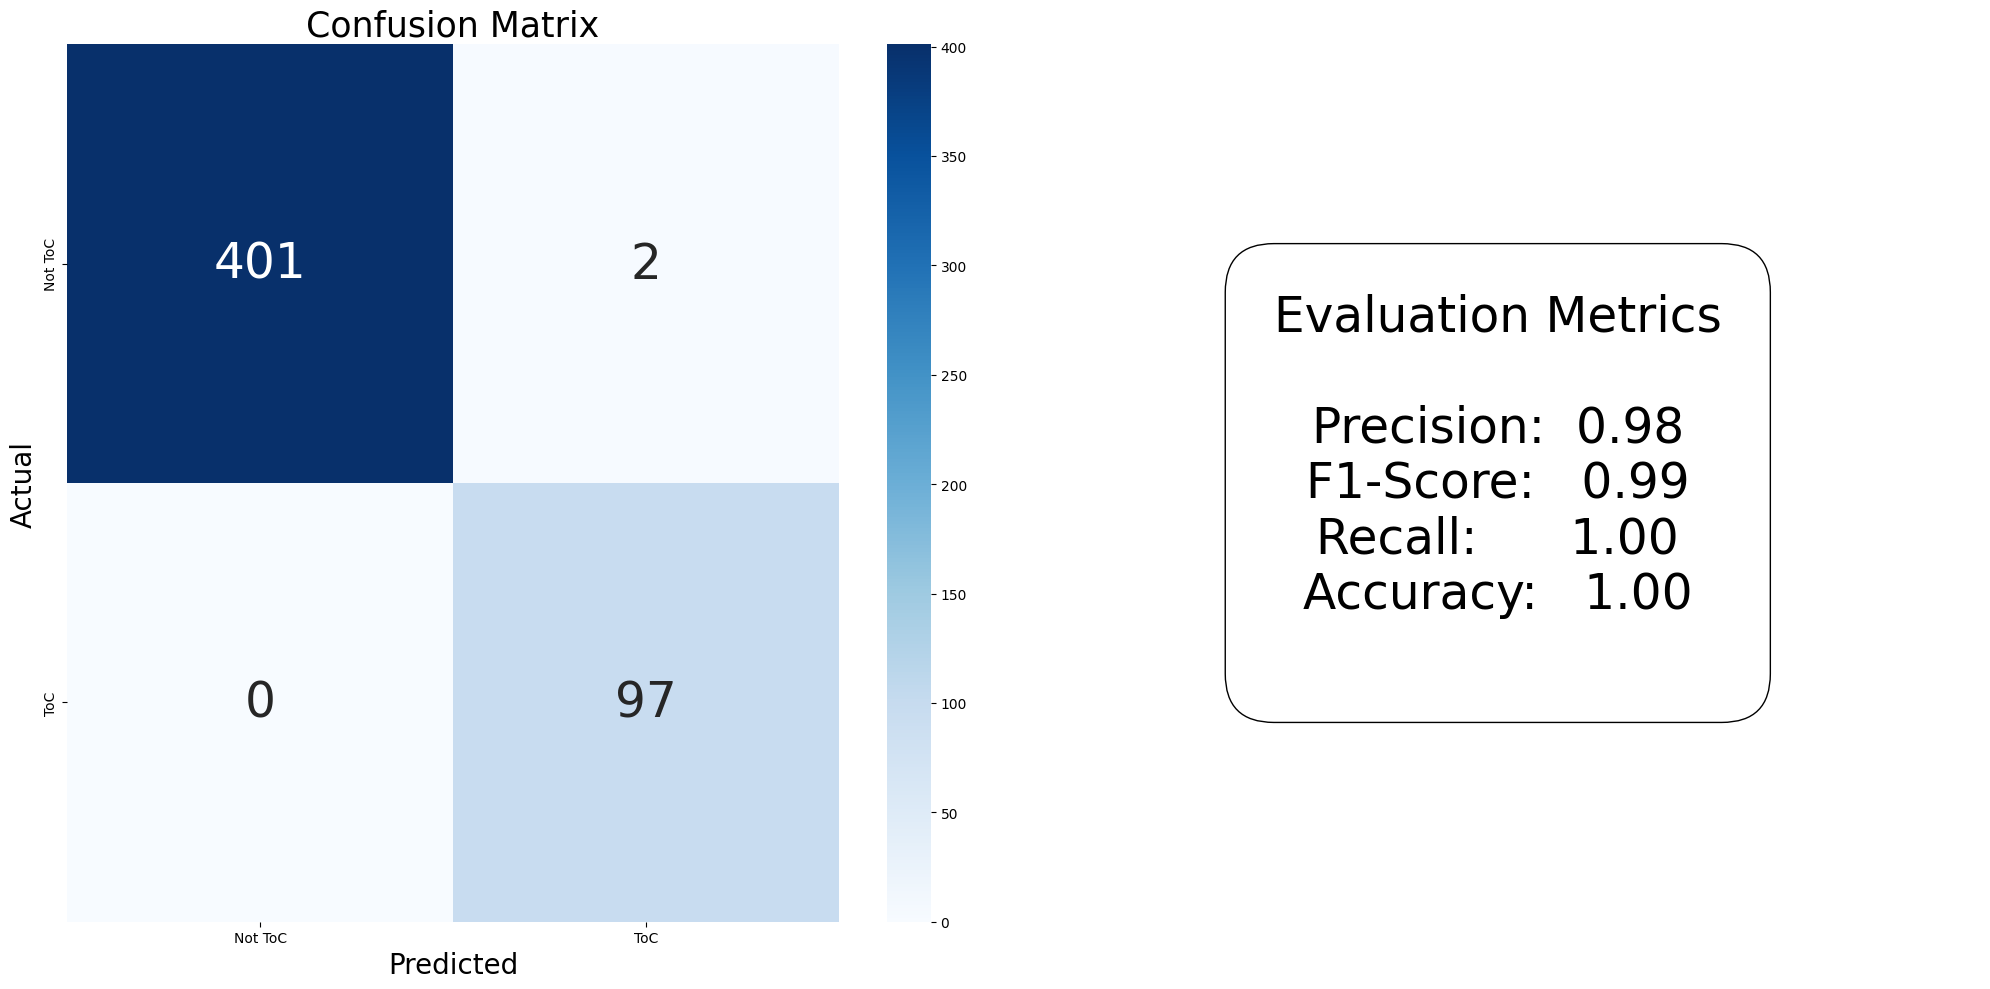

In [228]:
# Compute Confusion Matrix
cm = confusion_matrix(first_pages['toc'], first_pages['llm_toc'])
labels = ['Not ToC', 'ToC']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Compute Evaluation Metrics
accuracy = accuracy_score(first_pages['toc'], first_pages['llm_toc'])
precision = precision_score(first_pages['toc'], first_pages['llm_toc'], zero_division=0)
recall = recall_score(first_pages['toc'], first_pages['llm_toc'], zero_division=0)
f1 = f1_score(first_pages['toc'], first_pages['llm_toc'], zero_division=0)

metrics_text = (
    f"Evaluation Metrics\n\n"  
    f"Precision:  {precision:.2f}\n"
    f"F1-Score:   {f1:.2f}\n"
    f"Recall:      {recall:.2f}\n"
    f"Accuracy:   {accuracy:.2f}\n"
)

# Set the figure size
plt.figure(figsize=(20, 10))

# Create subplots: 1 row, 2 columns
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# ----------------------------
# Left: Confusion Matrix
# ----------------------------
sns.heatmap(
    cm_df, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    ax=ax1,
    annot_kws={"size": 35}
)
ax1.set_title('Confusion Matrix', fontsize=25)
ax1.set_ylabel('Actual', fontsize=20)
ax1.set_xlabel('Predicted', fontsize=20)

# ----------------------------
# Right: Metrics Text
# ----------------------------
ax2.axis('off')  # Hide the axis

# Add the metrics text
ax2.text(
    0.5, 0.5, 
    metrics_text, 
    horizontalalignment='center', 
    verticalalignment='center', 
    fontsize=35, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### False Postives Analysis

In [229]:
for _, row in first_pages[(first_pages['llm_toc'] == True) & (first_pages['toc'] == False)].iterrows():
    print(row['doc_id'], 'page number:', row['page_number'])
    print(row['clean_text'])
    print()
    print(row['masked_text'])
    print('-------------------')

tr73_0001070750_0001193125-13-073292 page number: 3
table of contents
to help investors understand the differences between host inc. and host l.p., this report presents the following separate sections or portions of sections for each of host inc. and host l.p.:
part ii item 5 – market for registrant’s common stock, related stockholder matters and issuer purchases of equity securities for host inc. / market for registrant’s common
units, related unitholder matters and issuer purchases of equity securities for host l.p.;
part ii item 6 – selected financial data;
part ii item 7 – management’s discussion and analysis of financial condition and results of operations is combined, except for a separate discussion of material differences, if
any, in the liquidity and capital resources between host inc. and host l.p.;
part ii item 7a – quantitative and qualitative disclosures about market risk is combined, except for separate discussions of material differences, if any, between host inc. and
ho

## Cover Page

In [230]:
# SYSTEM PROMPT

extract_cover_system = """You are an assistans specialized in Cover Page detection from SEC 10-K filings.

Your task is to reason about the input and detect if a provided page is a segment of the Cover Page or not.

To help you with your task the page text have been clean and numbers and years masked.
Here is a reference Cover Page:

'''indicate check mark whether registrant large accelerated filer accelerated filer non accelerated filer smaller reporting company emerging growth company see definitions large accelerated filer accelerated filer smaller reporting company emerging growth company rule 12b number exchange act company large accelerated filer accelerated filer non accelerated filer smaller reporting company emerging growth company check smaller reporting company emerging growth company indicate check mark registrant elected use extended transition period complying new revised financial accounting standards provided pursuant section number exchange act indicate check mark whether registrant shell company defined rule 12b number exchange act company yes dte electric yes month number year aggregate market value company voting non voting common equity held non affiliates approximately number number billion based new york stock exchange closing price date number shares common stock outstanding january number year registrant description shares company common stock without par value number number number company common stock number par value directly owned company number number number documents incorporated reference certain information company definitive proxy statement year annual meeting common shareholders held may number year filed securities exchange commission pursuant regulation 14a later number days end registrant fiscal year covered report form number k incorporated herein reference part iii items number number number number number form number k combined form number k filed separately two registrants company information contained herein relating individual registrant filed registrant solely behalf dte electric makes representation information relating exclusively company company wholly owned subsidiary company meets conditions set forth general instructions number b form number k therefore filing form reduced disclosure format specified general instruction number form number k cautionary statements unless otherwise indicated except context otherwise requires terms us company similar terms annual report form number k annual report refer ventas inc consolidated subsidiaries forward looking statements annual report includes forward looking statements within meaning section 27a securities act year amended securities act section 21e securities exchange act year amended exchange act forward looking statements include among others statements expectations beliefs future plans strategies anticipated results operations developments matters historical facts forward looking statements include among things statements regarding officers intent belief expectation identified use words assume may project expect believe intend anticipate seek target forecast plan potential opportunity estimate could would comparable derivative terms negatives thereof forward looking statements based management beliefs well number assumptions concerning future events put undue reliance forward looking statements guarantee performance subject number uncertainties factors could cause actual events results differ materially expressed implied forward looking statements undertake duty update forward looking statements speak date made urge carefully review disclosures make concerning risks uncertainties may affect business future financial performance including made summary risk factors item 1a risk factors report'''

These references are indicative; the actual text may vary slightly (company name, plurals, minor wording differences) but should remain easily recognizable as a part of a 10-K filling cover page.

Important notes:
Usually referes to stock number, market value, or filler size.
May contain a cautionary statement. However it is not mandatory, and if it is only a cautionary statement is likely not a cover page section.
If the page is a table of contents, it is not a cover page.

A common false positive (that should not pass as cover page) is the page where Item 1 is the headings followed by its narrative text.

You will be provided with the entire page text.
"""

In [231]:
first_pages['llm_cover'] = False

for document in tqdm(first_pages['doc_id'].unique()):
    print(f"Document ID: {document}")
    print()

    sys_messge = (SystemMessage(content=extract_cover_system + "\n" + parser_cover.get_format_instructions()))

    messages = [sys_messge]

    llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
    llm = llm.with_structured_output(DetectionAnswerCover)
        
    is_last_true = False
    any_detection = False

    for _, row in first_pages[first_pages['doc_id'] == document].iterrows():
        n = row['page_number']
        page = row['masked_text']

        if row['llm_toc']:
            print(f"Page {n} is a TOC. Early Exit")
            break

        if is_last_true:
            human_message = f'Previous page was segment of the cover page. Is the following page the continuation of it? \n\n{page}'
        else:
            human_message = f'Is the following page a segment of the cover page? \n\n{page}'

        messages.append(HumanMessage(content=human_message))     
        response = llm.invoke(messages)

        if is_last_true and not response.result:
            print(f"Page {n} is not a cover page. Eearly stop")
            print(response.reasoning)
            print()
            break

        if response.result:
            ai_message = f'Previous page is a cover page or a frament of it. \n\nPrevious reasoning: {response.reasoning}'
            messages.append(AIMessage(content=ai_message))
            is_last_true = True
            any_detection = True
            first_pages.loc[(first_pages['doc_id'] == document) & (first_pages['page_number'] == n), 'llm_cover'] = True

            print(f"Page {n} is a cover page")
            print(response.reasoning)
            print()
        else:
            print(f"Page {n} is not a cover page")
            print(response.reasoning)
            print()
    if not any_detection:
        print("No cover page detected")

    print('~~~~~~~~~~~~~~~~~~~~')
    # for m in messages:
    #     print(type(m))
    #     print(m.content)
    #     print()
    print('-------------------')

  0%|          | 0/100 [00:00<?, ?it/s]

Document ID: tr00_0000001800_0001047469-15-001377

Page 1 is not a cover page
The provided text begins with 'item 1 business' and contains detailed narrative descriptions about Abbott Laboratories' business segments and operations. This indicates that it is part of the main body of the 10-K filing, specifically the section discussing business operations, rather than the cover page. Additionally, it does not contain any of the typical elements found on a cover page, such as stock numbers, market value, or filer size. Therefore, this page is not a cover page or a segment of it.

Page 2 is not a cover page
The provided text contains detailed descriptions of various pharmaceutical products and segments of Abbott Laboratories' business operations. It does not reference stock numbers, market value, or any of the typical elements found on a cover page of a 10-K filing. Additionally, it appears to be part of the narrative for Item 1 (Business) rather than the cover page. Therefore, this page i

  1%|          | 1/100 [00:12<20:08, 12.20s/it]

Page 5 is not a cover page
The provided text does not contain any elements typical of a cover page from a 10-K filing. It discusses various operational aspects, research and development expenditures, environmental matters, and regulatory compliance, which are more characteristic of the business narrative sections of the filing. There are no references to stock numbers, market value, or filer size, nor does it contain any cautionary statements that would indicate it is part of the cover page. Additionally, it does not resemble a table of contents. Therefore, this page is not a segment of the cover page.

No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr01_0000002488_0000002488-16-000111

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr02_0000004127_0000004127-20-000058

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr03_0000004962_0000004962

  6%|▌         | 6/100 [00:13<02:46,  1.77s/it]

Page 1 is a cover page
The page contains references to the registrant's status as a large accelerated filer, accelerated filer, non-accelerated filer, and smaller reporting company, which are typical elements found on a cover page. It also includes information about the aggregate market value of voting stock held by non-affiliates, which is another common feature of cover pages. Additionally, it mentions the incorporation of definitive proxy statements and references to the annual meeting of shareholders, which are relevant to the cover page context. Therefore, this page is likely a segment of the cover page.

Page 2 is a TOC. Early Exit
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr06_0000020286_0000020286-18-000012



  7%|▋         | 7/100 [00:15<02:38,  1.70s/it]

Page 1 is a cover page
The page contains several indicators typical of a cover page, such as references to the registrant's status as a large accelerated filer, the market value of voting stock, and mentions of the definitive proxy statement. It also includes check marks for various classifications, which is common in cover pages. There is no indication that this is a table of contents or a narrative section from Item 1. Therefore, this page is likely a segment of the cover page.

Page 2 is a TOC. Early Exit
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr07_0000029534_0001558370-17-002116

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr08_0000029989_0000029989-18-000004

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr09_0000031462_0001558370-22-002059

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr1

 13%|█▎        | 13/100 [00:16<01:04,  1.34it/s]

Page 1 is not a cover page
The page contains references to a table of contents and includes terms like 'table contents' and 'documents incorporated reference', which suggest it is not a cover page. Additionally, it discusses market value and stock information, but the presence of 'table contents' indicates it is likely part of a TOC rather than the cover page itself. Therefore, it does not qualify as a cover page or a segment of it.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr13_0000049196_0001193125-14-054675



 14%|█▍        | 14/100 [00:17<01:10,  1.22it/s]

Page 1 is a cover page
The page contains several indicators typical of a cover page, including references to the registrant's filing status, market value, and classifications such as 'large accelerated filer' and 'smaller reporting company'. It also includes a check mark section which is common in cover pages. There is no indication that this is a table of contents or a narrative section from Item 1. Therefore, it is reasonable to conclude that this page is a segment of the cover page.

Page 2 is a TOC. Early Exit
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr14_0000063754_0000063754-15-000013

Page 1 is not a cover page
The page contains information about shares outstanding and references to documents incorporated by reference, which are typical elements found on a cover page of a 10-K filing. However, it lacks the specific language and structure that clearly identifies it as a cover page segment, such as market value or filer size. It also does not appear to be a table of c

 15%|█▌        | 15/100 [00:25<02:45,  1.95s/it]

Page 5 is not a cover page
The text provided does not contain any elements that are typically found on a cover page of a 10-K filing. It discusses various aspects of the business, including risks, competition, and financial conditions, but does not include key identifiers such as stock numbers, market value, or the registrant's status as a filer. Additionally, it does not contain any cautionary statements that are characteristic of cover pages. Therefore, this page is not a segment of the cover page.

No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr15_0000066740_0001558370-16-003162

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr16_0000070858_0000070858-14-000012



 17%|█▋        | 17/100 [00:27<02:16,  1.65s/it]

Page 1 is a cover page
The text contains references to stock numbers, market values, and mentions of the registrant's status as a large accelerated filer, which are typical elements found in a cover page of a 10-K filing. It also includes a check mark section for various classifications of the registrant, which is characteristic of cover pages. There are no indications that this is a table of contents or a narrative section from Item 1. Therefore, this page is likely a segment of the cover page.

Page 2 is a TOC. Early Exit
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr17_0000072903_0000072903-16-000123

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr18_0000072971_0000072971-22-000096

Page 1 is not a cover page
The provided text begins with 'part item 1 business' which indicates that it is part of the narrative text for Item 1 of the 10-K filing. This suggests that it is not a cover page segment. Additionally, the t

 19%|█▉        | 19/100 [00:36<03:23,  2.51s/it]

Page 5 is not a cover page
The provided text does not contain any elements typical of a cover page from a 10-K filing. It primarily discusses regulatory matters, deposit insurance assessments, and various acts affecting the financial services industry. There are no references to stock numbers, market value, or the typical cautionary statements found on a cover page. Additionally, it appears to be part of the narrative text related to Item 1, which is not characteristic of a cover page segment.

No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr19_0000075362_0001564590-21-006370

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr20_0000076334_0000076334-13-000157

Page 1 is not a cover page
The provided text contains detailed information about the company, its business segments, and financial data, which is characteristic of the narrative sections of a 10-K filing. However, it does not include any of t

 21%|██        | 21/100 [00:44<03:57,  3.01s/it]

Page 5 is not a cover page
The provided text does not contain any elements typical of a cover page from a 10-K filing. It appears to be a detailed description of various business segments and their products, which is more characteristic of the main body of the report rather than the cover page. The cover page usually includes information about the company, its filing status, and market value, rather than detailed product descriptions. Additionally, there are no references to stock numbers, market value, or cautionary statements that are commonly found on cover pages. Therefore, this page is not a segment of the cover page.

No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr21_0000077360_0000077360-15-000007

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr22_0000080424_0000080424-15-000070

Page 1 is not a cover page
The provided text does not contain any elements typical of a cover page from a 10-K

 29%|██▉       | 29/100 [00:54<01:48,  1.52s/it]

Page 5 is not a cover page
The provided text does not contain any elements typical of a cover page from a 10-K filing. It discusses various business risks, operations, and financial conditions, which are more characteristic of the main body of the report rather than the cover page. Additionally, it does not reference stock numbers, market value, or any of the specific checkboxes or cautionary statements typically found on a cover page. Therefore, this page is not a segment of the cover page.

No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr23_0000084839_0001171200-17-000077

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr24_0000091142_0001193125-13-080129

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr25_0000093410_0000093410-13-000003

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document 

 37%|███▋      | 37/100 [00:57<00:59,  1.06it/s]

Page 2 is not a cover page. Eearly stop
The text primarily consists of cautionary statements and forward-looking statements, which are common in 10-K filings but do not specifically indicate that this page is a continuation of the cover page. It lacks the key elements typically found on a cover page, such as market value, shares outstanding, or registrant information. Therefore, it is not a continuation of the cover page.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr37_0000759944_0000759944-15-000016

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr38_0000764180_0000764180-19-000023

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr39_0000765880_0001628280-19-001407

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr40_0000769397_0000769397-15-000012



 41%|████      | 41/100 [00:58<00:46,  1.27it/s]

Page 1 is not a cover page
The page is explicitly stated to be a 'table contents page intentionally left blank', which indicates that it is not part of the cover page. A table of contents is not a cover page segment, and since this page is blank, it does not contain any relevant information typically found on a cover page.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr41_0000804328_0001234452-16-000552

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr42_0000813828_0001047469-13-001192

Page 1 is not a cover page
The provided text contains detailed information about the business segments of CBS Corporation, including descriptions of various operations and financial contributions from each segment. This text appears to be part of Item 1 (Business) of the 10-K filing, which is not part of the cover page. The cover page typically includes information about the registrant

 43%|████▎     | 43/100 [01:06<01:15,  1.32s/it]

Page 5 is not a cover page
The provided text does not contain any elements typical of a cover page from a 10-K filing. It discusses various business segments, operations, and competitive landscape, which are more aligned with the narrative sections of the filing rather than the cover page. There are no references to stock numbers, market value, or filer size, and it does not contain any cautionary statements that would indicate it is part of the cover page. Additionally, it does not resemble a table of contents. Therefore, this page is not a segment of the cover page.

No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr43_0000821189_0000821189-17-000017

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr44_0000827054_0000827054-20-000119

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr45_0000829224_0000829224-18-000052



 46%|████▌     | 46/100 [01:08<01:01,  1.15s/it]

Page 1 is not a cover page
The page provided is a table of contents, as it explicitly mentions 'table contents' and refers to documents incorporated by reference. It does not contain any elements typical of a cover page, such as stock numbers, market value, or cautionary statements. Therefore, it is not a segment of the cover page.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr46_0000829224_0000829224-21-000086



 53%|█████▎    | 53/100 [01:10<00:28,  1.65it/s]

Page 1 is not a cover page
The page provided is a table of contents, as it explicitly mentions 'table contents' and refers to documents incorporated by reference. It does not contain any elements typical of a cover page, such as stock numbers, market value, or cautionary statements. Therefore, it is not a segment of the cover page.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr47_0000833444_0000833444-19-000051

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr48_0000842023_0001193125-13-351961

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr49_0000858877_0000858877-16-000117

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr50_0000858877_0000858877-21-000013

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
D

 55%|█████▌    | 55/100 [01:13<00:38,  1.18it/s]

Page 2 is not a cover page
The provided text does not contain any references to stock numbers, market values, or filer sizes, which are typical indicators of a cover page. Additionally, it appears to be discussing financial measures and definitions rather than the introductory information typically found on a cover page. There are no cautionary statements or other elements that would suggest this is part of a cover page. Therefore, it is not a cover page or a segment of it.

Page 3 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr54_0000875045_0000875045-15-000005

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr55_0000877212_0000877212-17-000009

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr56_0000877212_0000877212-19-000011

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------

 61%|██████    | 61/100 [01:17<00:29,  1.31it/s]

Page 3 is not a cover page
The provided text is a table of contents and does not contain any elements that are characteristic of a cover page for a 10-K filing. It discusses the structure and operations of the company and its partnerships, but does not include any of the typical cover page content such as stock numbers, market value, or cautionary statements. Therefore, it is not a segment of the cover page.

Page 4 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr61_0000906345_0000906345-17-000009

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr62_0000927066_0001564590-16-013587

Page 1 is not a cover page
The provided text does not contain any elements typical of a cover page from a 10-K filing. It primarily discusses the business operations and financial information of the company, specifically focusing on the kidney care division and its services. There are no references t

 63%|██████▎   | 63/100 [01:29<01:00,  1.63s/it]

Page 5 is not a cover page
The provided text does not contain any elements typical of a cover page from a 10-K filing. It discusses operational costs, payment rates, and patient coverage details, which are more aligned with the narrative sections of the filing rather than the cover page. Additionally, there are no references to stock numbers, market values, or filer sizes, and it does not contain any cautionary statements that would indicate it is part of the cover page. Therefore, this page is not a segment of the cover page.

No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr63_0000936340_0000936340-18-000082



 64%|██████▍   | 64/100 [01:31<01:00,  1.67s/it]

Page 1 is a cover page
The text contains multiple references to the registrant's status as a large accelerated filer, smaller reporting company, and mentions of market value and common stock, which are typical elements found in a cover page of a 10-K filing. It also includes details about the registrant's common stock and the aggregate market value, which are indicative of cover page content. There are no indications that this is a table of contents or a narrative section from Item 1. Therefore, this page is likely a segment of the cover page.

Page 2 is a TOC. Early Exit
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr64_0000936468_0000936468-22-000008

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr65_0000943452_0001564590-15-000794

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr66_0001035267_0001035267-15-000014



 67%|██████▋   | 67/100 [01:33<00:46,  1.41s/it]

Page 1 is not a cover page
The page contains elements that are typically found in a cover page, such as check marks for registrant classifications (large accelerated filer, accelerated filer, etc.), market value information, and references to stock and common equity. However, it also includes phrases like 'table contents' and 'definitive proxy information statements incorporated reference part iii form 10 k amendment form 10 k', which suggest that it may be part of a table of contents or a section that is not solely focused on the cover page. The presence of these phrases indicates that this page is likely not a complete cover page but rather a segment that includes cover page elements. Therefore, it is not a full cover page segment.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr67_0001043277_0001043277-14-000004

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr68_00

 71%|███████   | 71/100 [01:35<00:30,  1.05s/it]

Page 1 is not a cover page
The text provided does not contain any elements typically associated with a cover page of a 10-K filing, such as stock numbers, market value, or filer size. It appears to reference documents and filing timelines, which are not indicative of a cover page. Additionally, there is no cautionary statement present. Therefore, this page is not a cover page or a segment of it.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr71_0001063761_0001558370-24-001532

Page 1 is not a cover page
The provided text is a table of contents (TOC) for the annual report, as indicated by the phrase 'table contents' at the beginning. It outlines the structure of the report and does not contain any elements typical of a cover page, such as stock numbers, market value, or cautionary statements. Therefore, this page is not a segment of the cover page.



 72%|███████▏  | 72/100 [01:39<00:37,  1.35s/it]

Page 2 is not a cover page
The provided text is a table of contents, as it outlines various sections and items related to the report, including discussions on financial statements, market equity, and controls procedures. It does not contain any elements typical of a cover page, such as stock numbers, market value, or cautionary statements. Therefore, it is not a segment of the cover page.

Page 3 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr72_0001065280_0001065280-19-000043

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr73_0001070750_0001193125-13-073292

Page 1 is not a cover page
The text provided refers to documents incorporated by reference and mentions a definitive proxy statement, which is typically not part of the cover page of a 10-K filing. It does not contain any information about stock numbers, market value, or filer size, nor does it include any cautionary st

 74%|███████▍  | 74/100 [01:42<00:36,  1.42s/it]

Page 2 is not a cover page
The provided text is a table of contents (TOC) for the report, as it outlines the structure and references to various sections of the annual report. It does not contain any elements typical of a cover page, such as stock numbers, market value, or cautionary statements. Therefore, it is not a segment of the cover page.

Page 3 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr74_0001070750_0001564590-15-000907



 80%|████████  | 80/100 [01:44<00:14,  1.37it/s]

Page 1 is not a cover page
The provided text does not contain any elements typical of a cover page from a 10-K filing. It primarily discusses the structure and management of Host Hotels & Resorts, Inc. and its partnership with Host Hotels & Resorts, L.P. There are no references to stock numbers, market value, or filer size, which are common in cover pages. Additionally, it does not include any cautionary statements or check marks regarding the registrant's status. The content appears to be more of a narrative or explanatory note rather than a cover page segment. Therefore, this page is not a cover page or a fraction of it.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr75_0001093557_0001093557-15-000040

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr76_0001093557_0001193125-13-069590

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
----------

 83%|████████▎ | 83/100 [01:49<00:16,  1.02it/s]

Page 1 is not a cover page
The page contains elements that are typically found on a cover page, such as check marks for registrant status (large accelerated filer, accelerated filer, etc.), aggregate market value of voting stock, and references to the registrant's common stock. However, it also includes phrases like 'table contents' and appears to be a mix of cover page elements and table of contents information. Since it is not solely a cover page and includes references to filing requirements and a table of contents, it is not a complete cover page segment.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr83_0001324424_0001324424-23-000007

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr84_0001326801_0001326801-18-000009

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr85_0001393311_0001393311-13-000004

Page

 86%|████████▌ | 86/100 [01:54<00:16,  1.17s/it]

Page 2 is not a cover page. Eearly stop
The page begins with 'part item 1 business' and contains detailed narrative text regarding forward-looking statements and various risks associated with the business. This indicates that it is part of the narrative section of Item 1, rather than a continuation of the cover page. The content does not include any of the typical elements found on a cover page, such as check marks or market value information. Therefore, this page is not a continuation of the cover page.

~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr86_0001396009_0001396009-14-000006

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr87_0001403161_0001403161-19-000050

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr88_0001404912_0001047469-15-001418

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr89_0

 92%|█████████▏| 92/100 [01:57<00:07,  1.13it/s]

Page 1 is a cover page
The text contains multiple indicators typical of a cover page, such as references to the registrant's status as a well-known seasoned issuer, filing requirements, and details about the market value of common stock. It also includes check marks for various categories, which is characteristic of cover pages in 10-K filings. There are no indications that this is a table of contents or a narrative section from Item 1. Therefore, this page is likely a segment of the cover page.

Page 2 is a TOC. Early Exit
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr92_0001506307_0001506307-23-000023

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr93_0001510295_0001510295-18-000024

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr94_0001521332_0001521332-19-000007

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------


 97%|█████████▋| 97/100 [02:00<00:02,  1.22it/s]

Page 2 is not a cover page
The page provided is a table of contents (TOC) and includes a cautionary note regarding forward-looking statements. Since it is explicitly labeled as a TOC, it cannot be considered a segment of the cover page. Additionally, the content primarily discusses forward-looking statements, which is not sufficient to qualify as cover page material. Therefore, this page does not represent a cover page or a fraction of it.

Page 3 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr97_0001590895_0001590895-24-000051



 98%|█████████▊| 98/100 [02:02<00:01,  1.10it/s]

Page 1 is not a cover page
The page contains references to a definitive proxy statement and mentions the annual meeting of stockholders, which are typically not part of the cover page of a 10-K filing. It does not include any information about stock numbers, market value, or filer size, nor does it contain any cautionary statements that would indicate it is part of the cover page. Additionally, it does not resemble any recognizable segment of a cover page. Therefore, this page is not a cover page or a segment of it.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr98_0001590955_0001564590-20-004636

Page 1 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------
Document ID: tr99_0001601046_0001601046-22-000161



100%|██████████| 100/100 [02:04<00:00,  1.24s/it]

Page 1 is not a cover page
The provided text does not contain any elements typically associated with a cover page of a 10-K filing, such as stock numbers, market value, or filer size. Instead, it references documents and a proxy statement, which are not indicative of a cover page. Additionally, there are no cautionary statements or other recognizable features of a cover page. Therefore, this page is not a segment of the cover page.

Page 2 is a TOC. Early Exit
No cover page detected
~~~~~~~~~~~~~~~~~~~~
-------------------


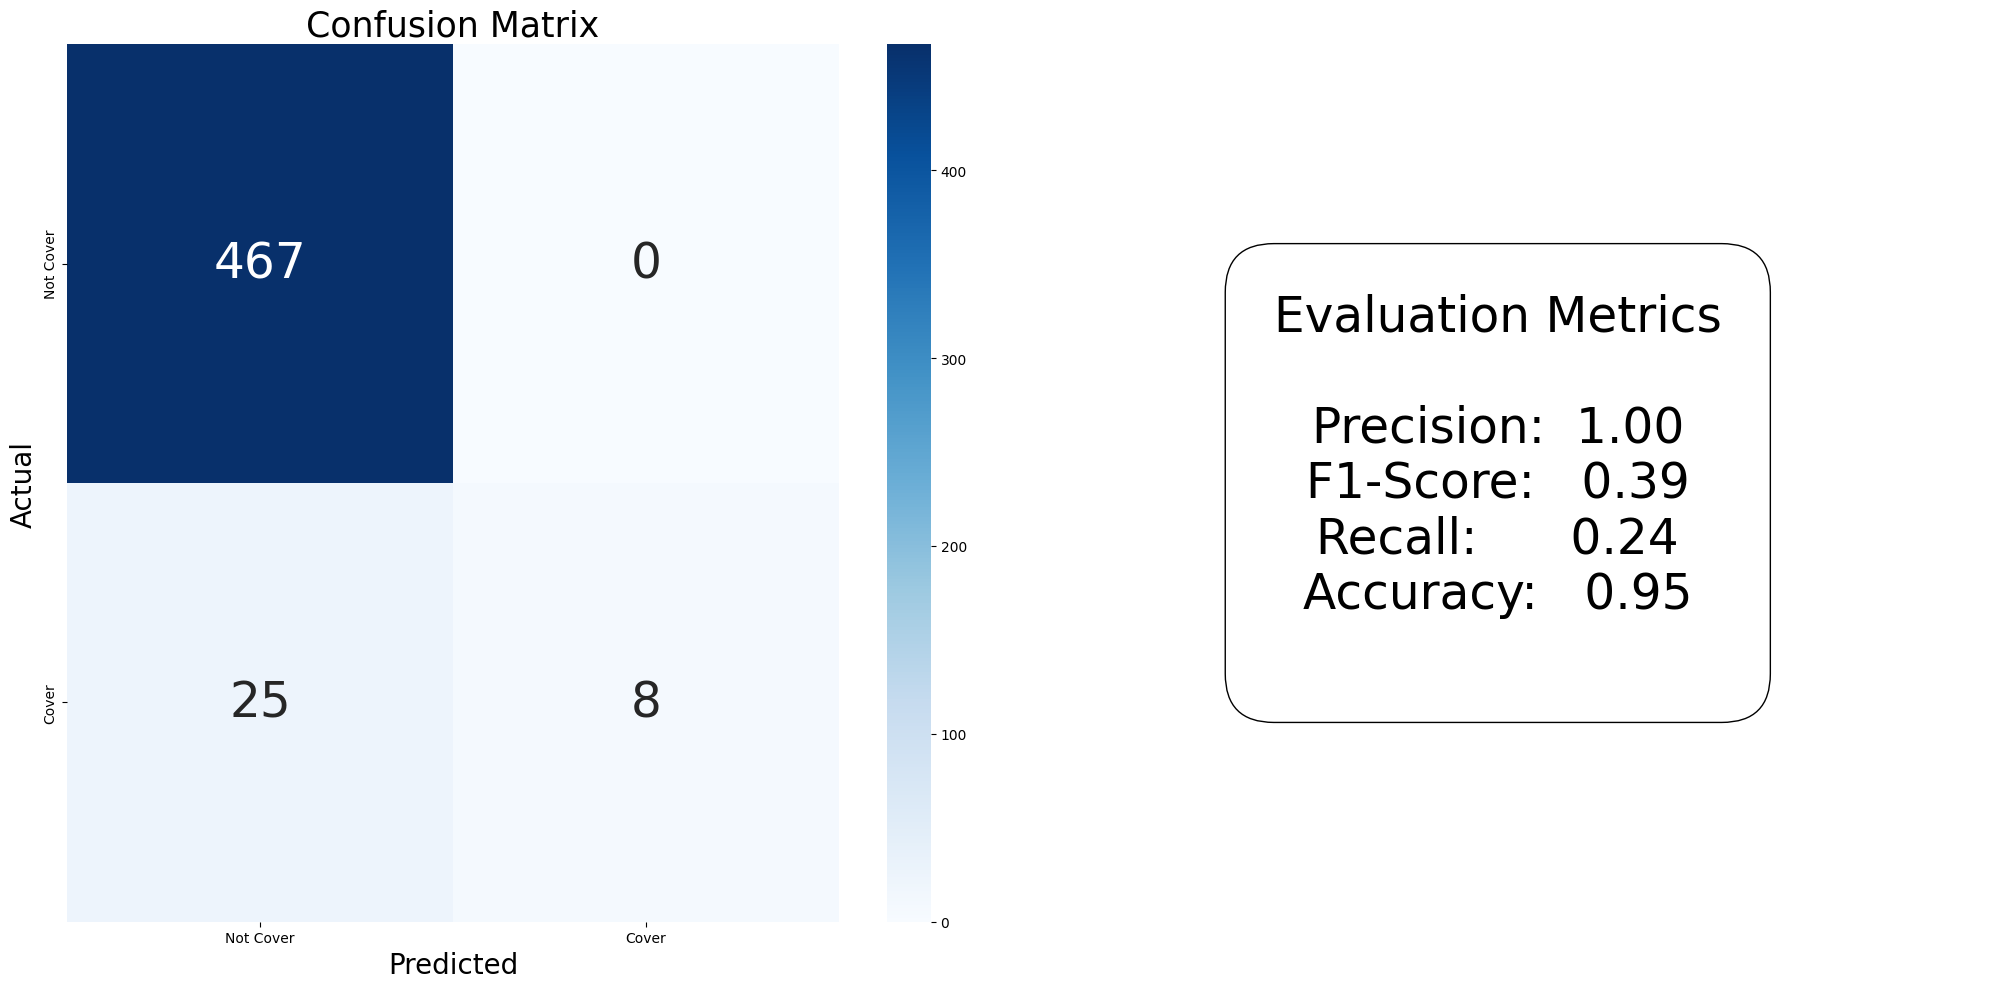

In [232]:
# Compute Confusion Matrix
cm = confusion_matrix(first_pages['cover'], first_pages['llm_cover'])
labels = ['Not Cover', 'Cover']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Compute Evaluation Metrics
accuracy = accuracy_score(first_pages['cover'], first_pages['llm_cover'])
precision = precision_score(first_pages['cover'], first_pages['llm_cover'], zero_division=0)
recall = recall_score(first_pages['cover'], first_pages['llm_cover'], zero_division=0)
f1 = f1_score(first_pages['cover'], first_pages['llm_cover'], zero_division=0)

metrics_text = (
    f"Evaluation Metrics\n\n"  
    f"Precision:  {precision:.2f}\n"
    f"F1-Score:   {f1:.2f}\n"
    f"Recall:      {recall:.2f}\n"
    f"Accuracy:   {accuracy:.2f}\n"
)

# Set the figure size
plt.figure(figsize=(20, 10))

# Create subplots: 1 row, 2 columns
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# ----------------------------
# Left: Confusion Matrix
# ----------------------------
sns.heatmap(
    cm_df, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    ax=ax1,
    annot_kws={"size": 35}
)
ax1.set_title('Confusion Matrix', fontsize=25)
ax1.set_ylabel('Actual', fontsize=20)
ax1.set_xlabel('Predicted', fontsize=20)

# ----------------------------
# Right: Metrics Text
# ----------------------------
ax2.axis('off')  # Hide the axis

# Add the metrics text
ax2.text(
    0.5, 0.5, 
    metrics_text, 
    horizontalalignment='center', 
    verticalalignment='center', 
    fontsize=35, 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
)
    

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# Update Dfs


In [233]:
for file_name in file_names:
    toc_pages = first_pages[(first_pages['doc_id'] == file_name)&(first_pages['tfidf_toc'] >= ttoc)]['page_number'].to_list()

    if toc_pages:
        # cover_pages = all numbers from 1 to the min of toc pages (excluded)
        cover_pages = list(range(1, min(toc_pages)))
    else:
        cover_pages = first_pages[(first_pages['doc_id'] == file_name)&(first_pages['emb_sim_cover']>=tcp)]['page_number'].to_list()
    print('Document:', file_name)
    print('ToC pages:', toc_pages)
    print('Cover pages:', cover_pages)
    print()

    df = pd.read_parquet(f'outputs/train/{file_name}/initial_df.parquet')
    if toc_pages:
        # where page number is in toc_pages chante is_noise to True and noise_type to 'toc'
        df.loc[df['page_number'].isin(toc_pages), 'is_noise'] = True
        df.loc[df['page_number'].isin(toc_pages), 'noise_type'] = 'toc'
    if cover_pages:
        # where page number is in cover_pages chante is_noise to True and noise_type to 'cover'
        df.loc[df['page_number'].isin(cover_pages), 'is_noise'] = True
        df.loc[df['page_number'].isin(cover_pages), 'noise_type'] = 'cover'

    # where page_numner = 0 cover page
    df.loc[df['page_number'] == 0, 'is_noise'] = True
    df.loc[df['page_number'] == 0, 'noise_type'] = 'cover'

    # if a page has a detected_page_number, all row with the same page_number must have the detected_page_number equal to that one
    detected_page_numbers = df.groupby('page_number')['detected_page_number'].first()
    # Map the detected_page_number back to the original DataFrame
    df['detected_page_number'] = df['page_number'].map(detected_page_numbers)


    df.to_parquet(f'outputs/train/{file_name}/df_toc.parquet')


Document: tr00_0000001800_0001047469-15-001377
ToC pages: []
Cover pages: []

Document: tr01_0000002488_0000002488-16-000111
ToC pages: [1]
Cover pages: []

Document: tr02_0000004127_0000004127-20-000058
ToC pages: [1]
Cover pages: []

Document: tr03_0000004962_0000004962-23-000006
ToC pages: [1]
Cover pages: []

Document: tr04_0000010456_0001628280-24-003932
ToC pages: [1]
Cover pages: []

Document: tr05_0000020286_0000020286-17-000013
ToC pages: [2]
Cover pages: [1]

Document: tr06_0000020286_0000020286-18-000012
ToC pages: [2]
Cover pages: [1]

Document: tr07_0000029534_0001558370-17-002116
ToC pages: [1]
Cover pages: []

Document: tr08_0000029989_0000029989-18-000004
ToC pages: [1]
Cover pages: []

Document: tr09_0000031462_0001558370-22-002059
ToC pages: [1]
Cover pages: []

Document: tr10_0000034088_0000034088-22-000011
ToC pages: [1]
Cover pages: []

Document: tr11_0000045012_0000045012-18-000059
ToC pages: [1]
Cover pages: []

Document: tr12_0000046080_0000046080-24-000034
ToC 